In [1]:
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import Image
import pandas as pd
import math
import numpy as np

In [2]:
URL_1 = "https://www.topuniversities.com"
URL_2 = 'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats'

# 1) www.topuniversities.com (ranking 2018)

### Explain about the magic token
* First of all, try to look aroud by inspecting some elements in the website. I searched some 'key words' like 'EPFL' or 'MIT' in box seared (see below)... in order to see how the data is fetched by server site. Luckily, we can very well see that data of this ranking is stored in a text file named '357051.txt'. And then, you know, we just have to take the link (MAGIC_TOKEN_1) in which goes directly to JSON file database <3

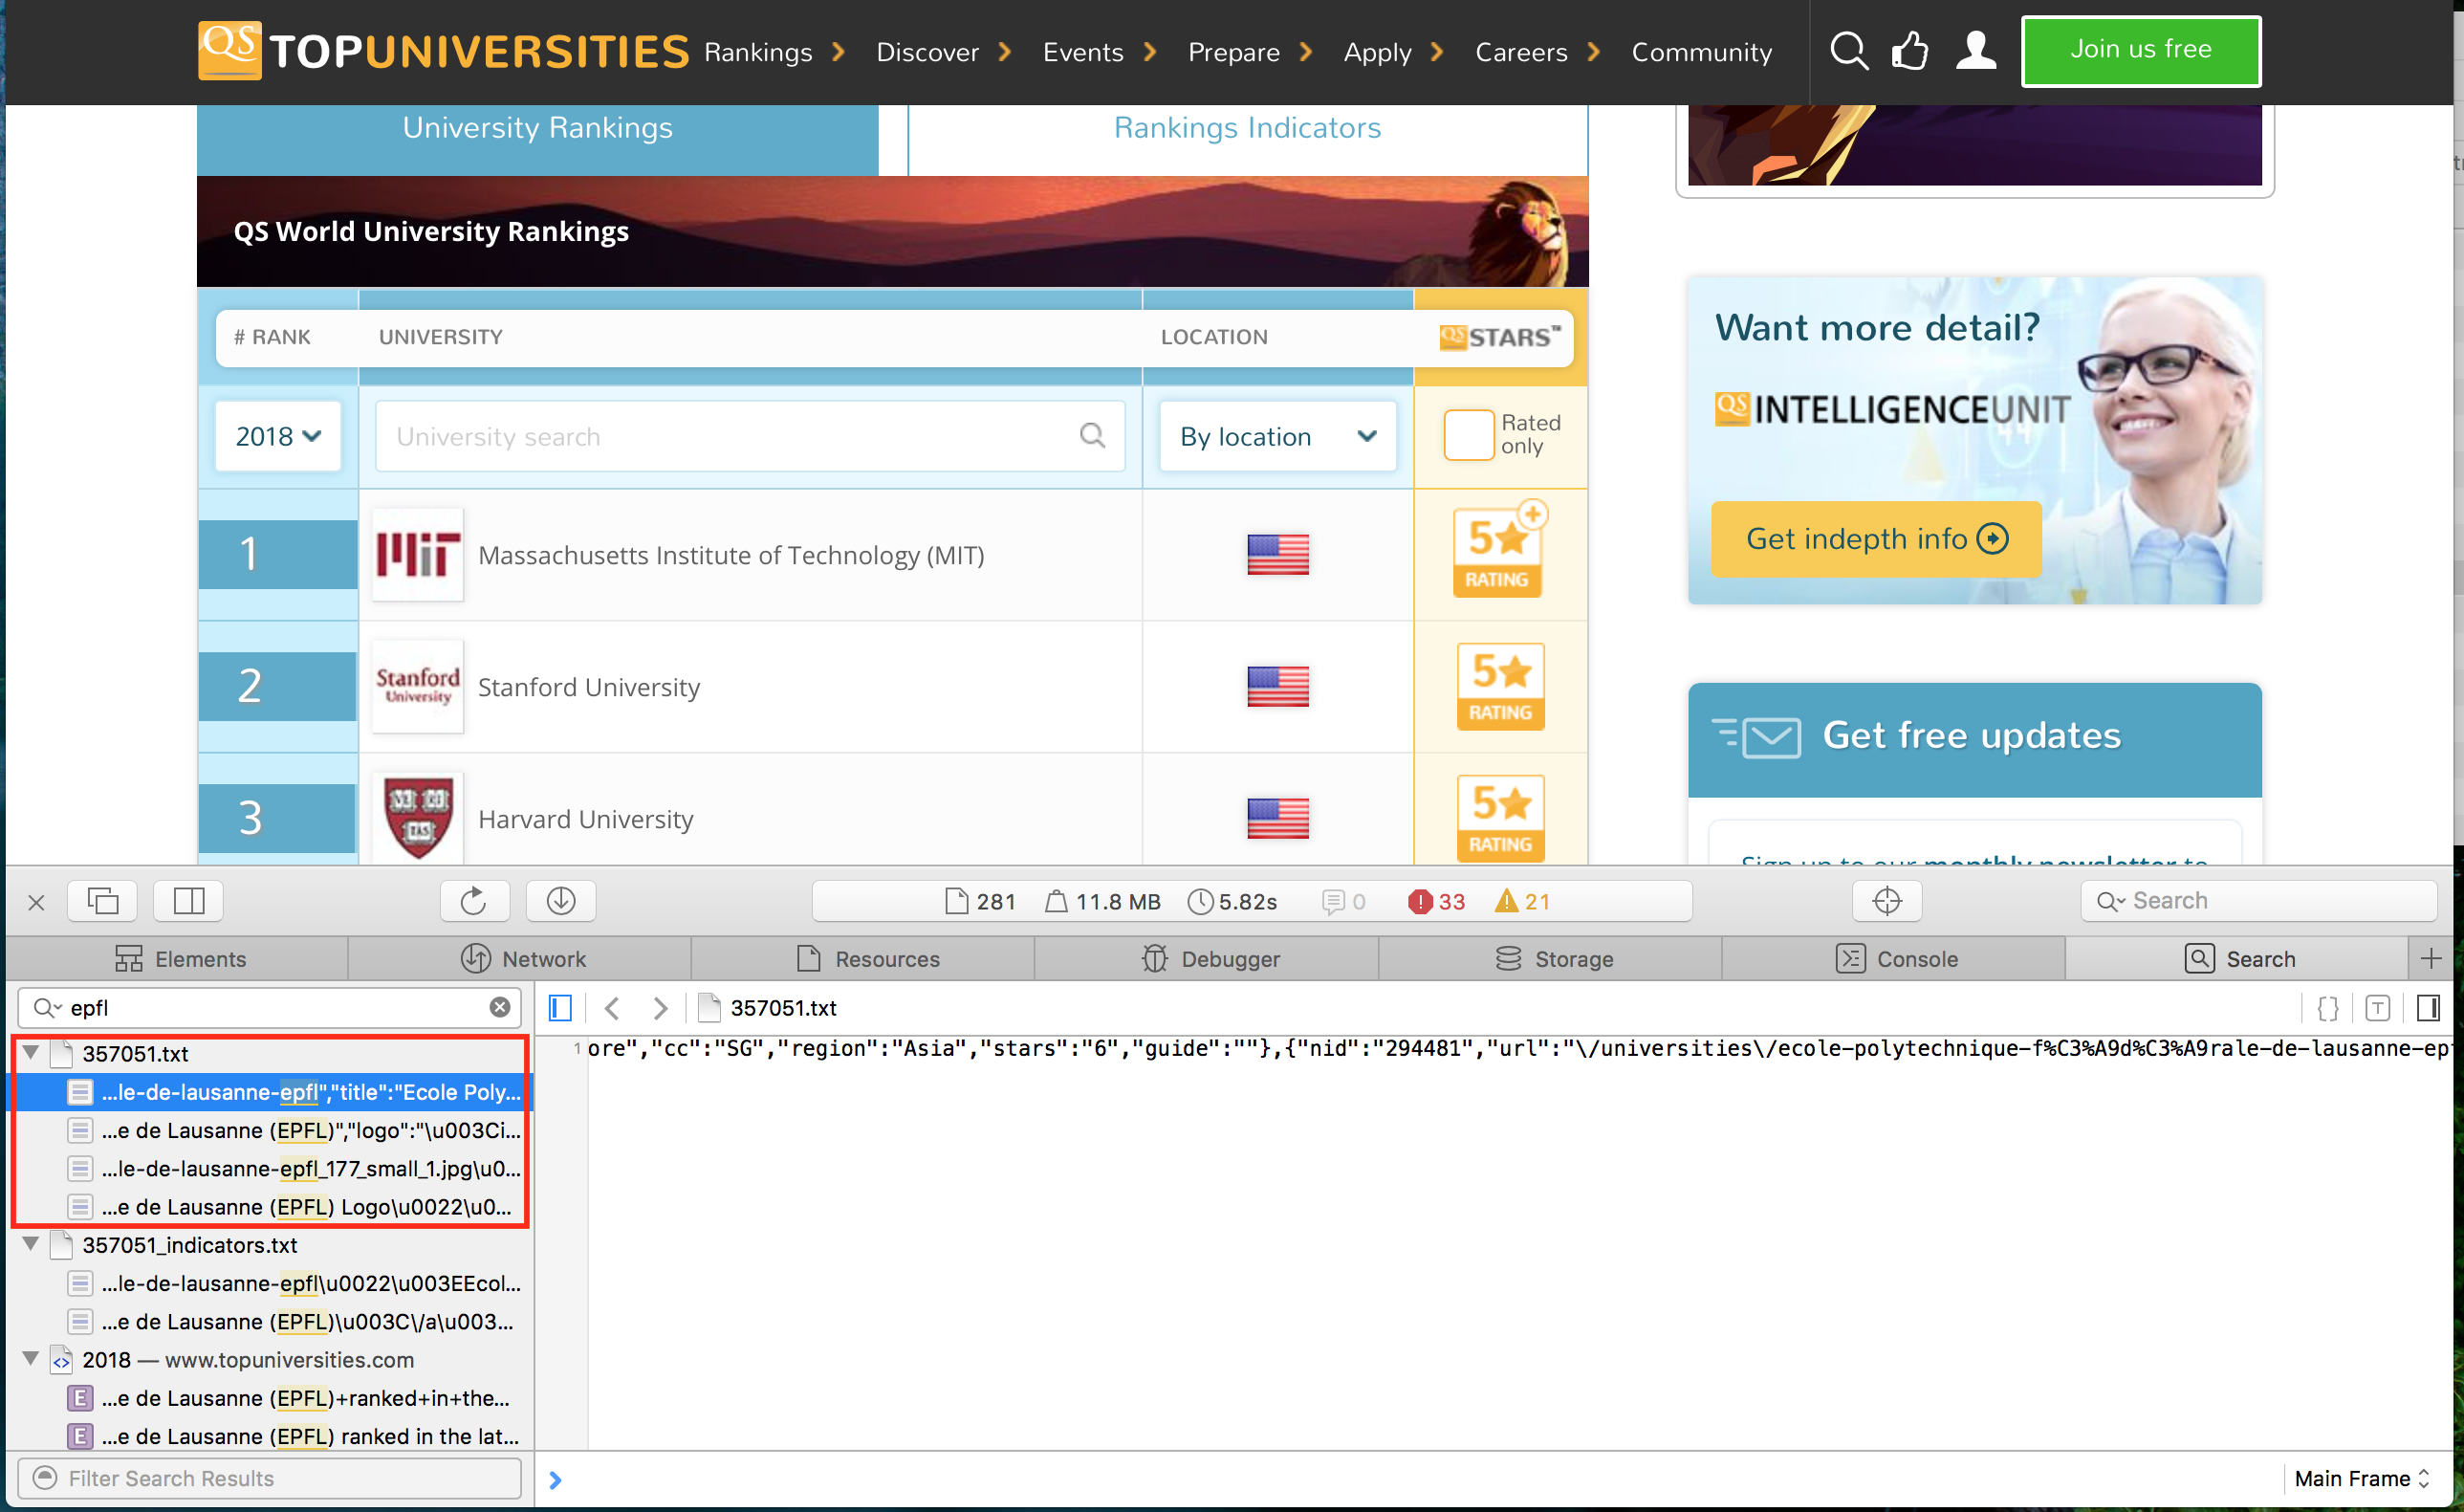

In [3]:
Image(filename='../data_1_detected.png')

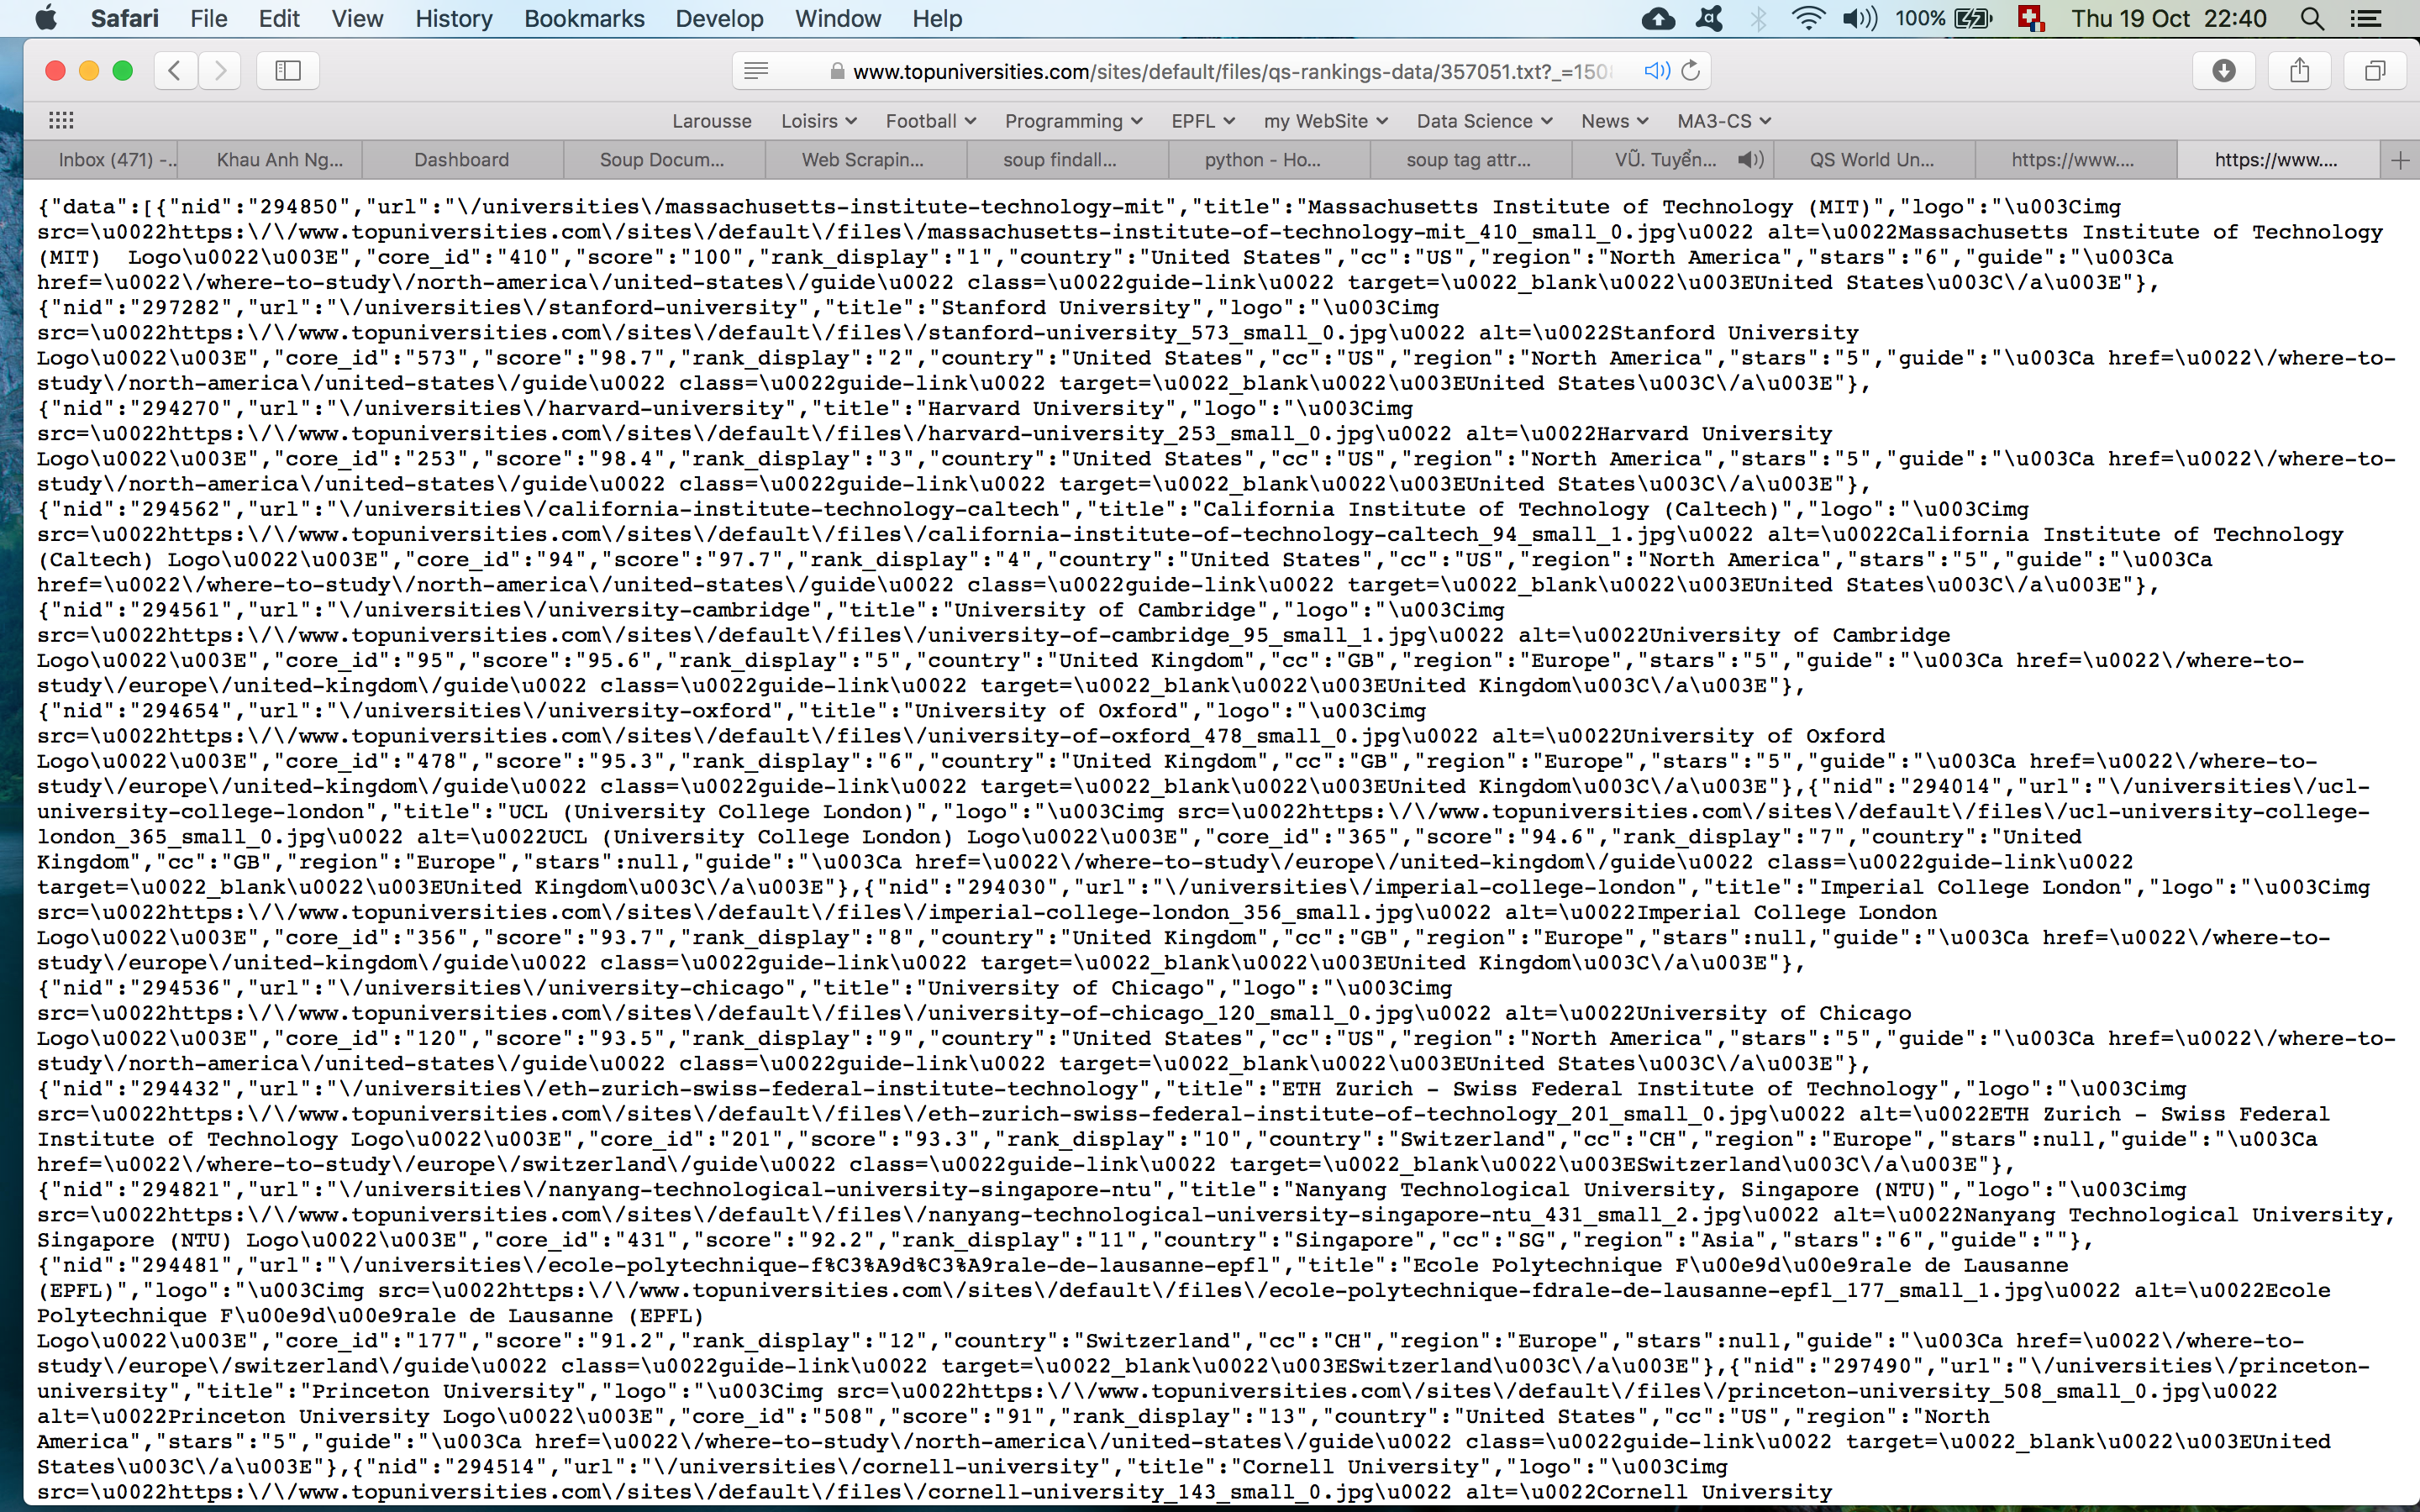

In [4]:
"""JSON database of ranking"""
Image(filename='../data_1.png')

In [5]:
"""Load the data"""

MAGIC_TOKEN_1 = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
data_1 = requests.get(MAGIC_TOKEN_1)
data_1 = json.loads(data_1.text)
(data_1['data'][11])

{'cc': 'CH',
 'core_id': '177',
 'country': 'Switzerland',
 'guide': '<a href="/where-to-study/europe/switzerland/guide" class="guide-link" target="_blank">Switzerland</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/ecole-polytechnique-fdrale-de-lausanne-epfl_177_small_1.jpg" alt="Ecole Polytechnique Fédérale de Lausanne (EPFL) Logo">',
 'nid': '294481',
 'rank_display': '12',
 'region': 'Europe',
 'score': '91.2',
 'stars': None,
 'title': 'Ecole Polytechnique Fédérale de Lausanne (EPFL)',
 'url': '/universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl'}

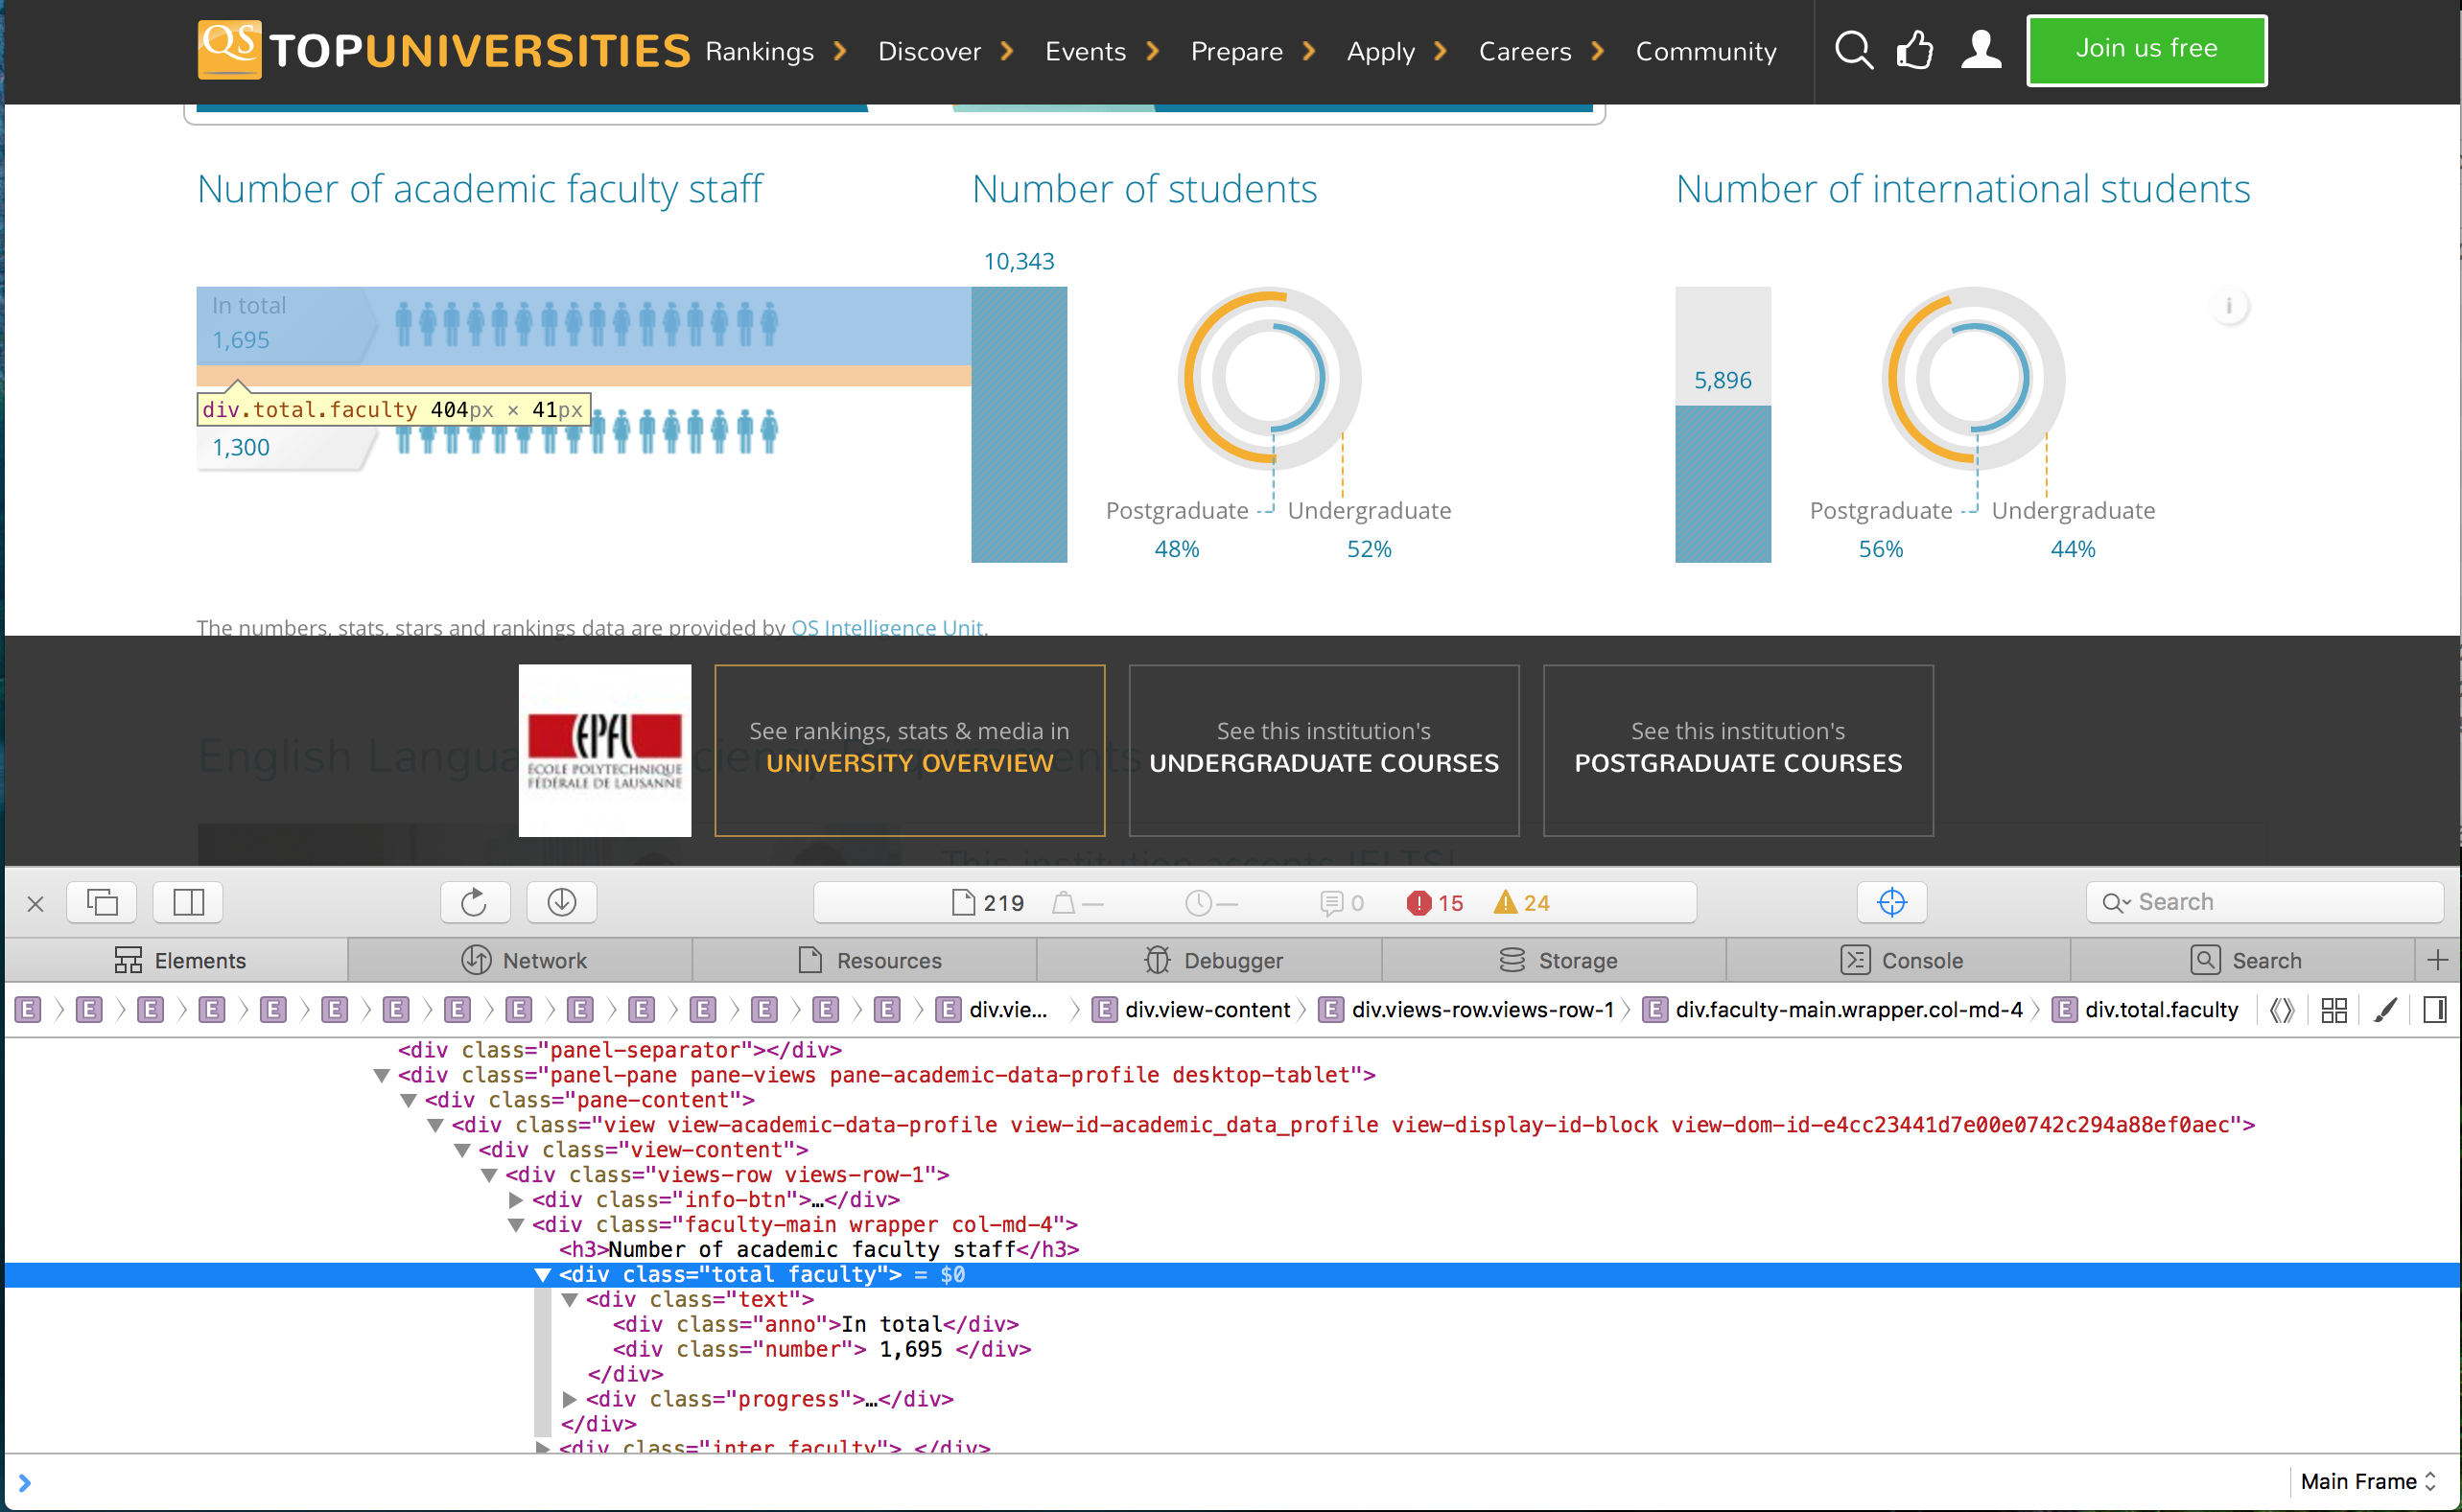

In [6]:
""" No magic token now, we have to scrape data...
    Try to find some useful informations/tags for scraping these details numbers"""
Image(filename='../scrap_numbers.png')

#### Assumption: in this homework, all NaN will be replace by int -999

In [7]:
"""
    This function try to scraps some useful number: total students, international students...
    If we don't found any thing => return []
    If there are somethings missing => replace missing value by int -999
    Otherwise just return 4 numbers in which correspond to 
                    ['total faculty', 'inter faculty', 'total student', 'total inter']
"""

def scrape_numbers(URL, name):
    re      = requests.get(URL)
    data    = BeautifulSoup(re.text, 'html.parser')
    targets = ['total faculty', 'inter faculty', 'total student', 'total inter']
    numbers = []
    
    """Try to search all attributes"""
    exist = data.find_all('div', attrs={'class': targets})
    if (not exist): 
        print ('No detail information found of',name)
        return []
    
    for target in targets:
        text = data.find_all('div', attrs={'class': target})
        if (len(text)==0) : 
            print ("No information found about number",target.upper(),"of", name)
            "Have a '.'before because in a valid case it has '\n1654' so we have to cut the first char"
            numbers.append('.-999')
            numbers.append('.-999')   
        else:
            for t in text:
                n = t.find('div', attrs={'class':'number'})  
                numbers.append(n.text)
            
    """each targeted number is stored 2 times  = [1,695 ; 1,695; 1,300; 1,300; 10,343; 10,343; 5,896; 5,896]"""
    """we have to re-format these number and remove duplicate"""

    numbers = [int(n[1:].replace(',','')) for n in numbers]
    numbers = numbers[1::2]
    
    return numbers

In [8]:
"""
    This function return a dataframe of ranking.
    In order to simplify for answering the questions, we computed some necessary information like:
        STUDENTS_PER_STAFF, INTERNATIONAL_STUDENT_RATIO...
        
    In order to merge (as well as we can) 2 rankings that comes up after, 
        we have to treat all special cases of the name of university
"""


def RANKING_1(data):
    
    names = []
    ranks = []
    countries = []
    regions = []
    total_std = []
    """Need for question a,b,c,d"""
    inter_students_ratio =[]
    std_per_staff = []

    N_stds = 200
    
    """Extract data"""
    for i in range(N_stds):
        d = data['data'][i]
        
        """Remove parenthese of name"""
        name = ((d['title'].split('('))[0])
        if (name[-1] == ' ') : name = name[:-1]
        if 'É' in name: name = name.replace('É','E')
        if '.' in name: # Washington University in St. Louis',
            s = name.split('.')
            name = ''.join(s)
        if 'ETH Zurich' in name: name ='ETH Zurich – Swiss Federal Institute of Technology Zurich'
        if ', Chapel Hill' in name: name = 'University of North Carolina at Chapel Hill'
        if ', The University of Dublin' in name: name = 'Trinity College Dublin'
        if 'Studi Universitari e di Perfezionamento' in name: name = 'Scuola Normale Superiore di Pisa'
        if 'Pohang University' in name: name = 'Pohang University of Science and Technology'
        if 'King’s College London'in name: name = "King's College London"
        if 'Humboldt-Universität' in name: name = 'Humboldt University of Berlin'
        if 'Freie Universitaet Berlin' in name: name = 'Free University of Berlin'
        names.append(name)
        
        rank = d['rank_display']
        ranks.append(int(rank[1:]) if '=' in rank else int(rank))
        countries.append(d['country'])
        regions.append(d['region'])
        numbers = scrape_numbers(URL_1 + d['url'], names[i])

        """['total faculty', 'inter faculty', 'total student', 'total inter']"""
        if len(numbers)==4 :
            t_f = numbers[0]
            i_f = numbers[1]
            t_s = numbers[2]
            t_i = numbers[3]
            total_std.append(int(t_s))
            if (t_i != -999 and t_i != -999):
                inter_students_ratio.append(round( float(t_i) / float(t_s), 2))
            else:
                inter_students_ratio.append(-999)
            if (t_s != -999 and t_f != -999):
                std_per_staff.append(round (float(t_s) / float(t_f), 1))
            else:
                std_per_staff.append(-999)

        else : 
            total_std           .append(-999)
            inter_students_ratio.append(-999)
            std_per_staff       .append(-999)
    
    """Create dataframe"""
    
    df = pd.DataFrame(
        {
          'RANK'                       : ranks,
          'UNIVERSITY'                 : names,
          'COUNTRY'                    : countries,
          'REGION'                     : regions,
          'STUDENTS_PER_STAFF'         : std_per_staff,
          'NUMBER_OF_STUDENTS'         : total_std,
          'INTERNATIONAL_STUDENT_RATIO': inter_students_ratio
        })    
    
    return df

In [9]:
df_1 = RANKING_1(data_1)

No detail information found of New York University
No information found about number INTER FACULTY of Indian Institute of Science


In [10]:
df_1

COUNTRY  INTERNATIONAL_STUDENT_RATIO  NUMBER_OF_STUDENTS  RANK  \
0     United States                         0.34               11067     1   
1     United States                         0.23               15878     2   
2     United States                         0.23               22429     3   
3     United States                         0.29                2255     4   
4    United Kingdom                         0.36               18770     5   
5    United Kingdom                         0.37               19720     6   
6    United Kingdom                         0.48               31080     7   
7    United Kingdom                         0.54               16090     8   
8     United States                         0.25               13557     9   
9       Switzerland                         0.38               19815    10   
10        Singapore                         0.28               25738    11   
11      Switzerland                         0.57               10343    12   
12    United States                         0.22                8069    13   
13    United States                         0.25               21904    14   
14        Singapore                         0.27               32728    15   
15    United States                         0.20               12402    16   
16    United States                         0.25               16146    17   
17    United States                         0.32               25045    18   
18    United States                         0.21               20639    19   
19        Australia                         0.38               14442    20   
20    United States                         0.17               43147    21   
21    United States                         0.19               15320    21   
22   United Kingdom                         0.38               28040    23   
23   United Kingdom                         0.40               23780    23   
24            China                         0.11               36300    25   
25        Hong Kong                         0.41               20214    26   
26    United States                         0.17               36703    27   
27            Japan                         0.10               27279    28   
28    United States                         0.18               18675    28   
29        Hong Kong                         0.28               10375    30   
..              ...                          ...                 ...   ...   
170         Germany                         0.17               23214   171   
171           India                         0.01                7477   172   
172    Saudi Arabia                         0.16                6040   173   
173  United Kingdom                         0.34               22065   173   
174   United States                         0.09               21560   173   
175       Australia                         0.32               24207   176   
176          France                         0.29                3877   177   
177   United States                         0.10               45485   178   
178           India                         0.01                9402   179   
179     Netherlands                         0.24                9332   179   
180         Germany                         0.12               30402   181   
181         Belgium                         0.20                9284   182   
182          Brazil                         0.04               26572   182   
183   United States                         0.09               30219   182   
184         Austria                         0.30               17479   182   
185   United States                         0.29                9636   186   
186           Spain                         0.11               26511   187   
187           Italy                         0.07               63399   188   
188  United Kingdom                         0.31               13330   188   
189           India               

## Question a

In [11]:
df_1a = df_1[['RANK', 'UNIVERSITY', 'STUDENTS_PER_STAFF']]
df_1a = df_1a.set_index('STUDENTS_PER_STAFF')
df_1a = df_1a.sort_index(axis=0,ascending=False)
df_1a

RANK                                    UNIVERSITY
STUDENTS_PER_STAFF                                                    
 24.8                182               Vienna University of Technology
 24.2                170                         Politecnico di Milano
 23.9                125                     Free University of Berlin
 22.9                 61                      University of Washington
 21.2                188  Alma Mater Studiorum - University of Bologna
 21.0                152                        University of Waterloo
 19.9                153              Université catholique de Louvain
 18.6                 70               Georgia Institute of Technology
 18.2                176               University of Technology Sydney
 18.1                 71                                     KU Leuven
 17.9                 60                             Monash University
 17.5                195                          Texas A&M University
 17.2                201                          Universidad de Chile
 16.9                120                 Humboldt University of Berlin
 16.9                 67                 University of Texas at Austin
 16.7                164              University of California, Irvine
 16.6                 69    University of Illinois at Urbana-Champaign
 16.0                172          Indian Institute of Technology Delhi
 16.0                134       University of California, Santa Barbara
 15.6                149                     Michigan State University
 14.6                195             Universitat Autònoma de Barcelona
 14.6                151                           University of Otago
 14.5                 82                    The University of Auckland
 14.3                125                              Ghent University
 14.3                107        KIT, Karlsruhe Institute of Technology
 14.0                 33         University of California, Los Angeles
 14.0                141                        RWTH Aachen University
 13.9                 50                      The University of Sydney
 13.6                161                 National Tsing Hua University
 13.6                 45             The University of New South Wales
...                  ...                                           ...
 5.6                 124                         Wageningen University
 5.5                   9                         University of Chicago
 5.3                 142                      University of Pittsburgh
 5.3                 157              Ecole Normale Supérieure de Lyon
 5.2                 182                    Vrije Universiteit Brussel
 5.2                   3                            Harvard University
 5.2                  76                             Tohoku University
 5.2                  21                               Duke University
 5.2                  73                          University of Zurich
 5.0                 147                              Emory University
 5.0                 100             Washington University in St Louis
 4.9                   7                                           UCL
 4.8                  59                           Ecole Polytechnique
 4.7                  71   Pohang University of Science and Technology
 4.5                  95             Lomonosov Moscow State University
 4.4                  28                       Northwestern University
 4.3                  73                      University of Copenhagen
 4.2                 116               Technical University of Denmark
 4.1                   8                       Imperial College London
 4.0                  18                           Columbia University
 3.8                  19                    University of Pennsylvania
 3.8                 186                       University of Rochester
 3.7                   1         Massachusetts Institute of Technology
 3.7                   2                    

## Question b

In [12]:
df_1b = df_1[['RANK', 'UNIVERSITY', 'INTERNATIONAL_STUDENT_RATIO']]
df_1b = df_1b.set_index('INTERNATIONAL_STUDENT_RATIO')
df_1b = df_1b.sort_index(axis=0,ascending=False)
df_1b

RANK  \
INTERNATIONAL_STUDENT_RATIO         
 0.69                          35   
 0.57                          12   
 0.54                           8   
 0.50                         200   
 0.48                           7   
 0.48                          47   
 0.46                          92   
 0.43                          41   
 0.42                         127   
 0.41                          26   
 0.40                          23   
 0.39                          57   
 0.39                         113   
 0.39                          98   
 0.38                         109   
 0.38                          20   
 0.38                          10   
 0.38                          23   
 0.37                          34   
 0.37                           6   
 0.36                          50   
 0.36                          60   
 0.36                          45   
 0.36                           5   
 0.36                         135   
 0.35                          49   
 0.35                         158   
 0.34                          65   
 0.34                          82   
 0.34                           1   
...                           ...   
 0.09                          76   
 0.09                         192   
 0.09                         134   
 0.09                         195   
 0.09                         173   
 0.09                         161   
 0.09                          63   
 0.09                         109   
 0.08                         195   
 0.08                          80   
 0.08                          36   
 0.08                         122   
 0.07                         192   
 0.07                          62   
 0.07                         164   
 0.07                         188   
 0.06                         145   
 0.06                         102   
 0.06                          41   
 0.05                         201   
 0.04                         182   
 0.04                         137   
 0.04                          71   
 0.03                         121   
 0.03                          97   
 0.02                         122   
 0.01                         190   
 0.01                         179   
 0.01                         172   
-999.00                        52   

                                                                    UNIVERSITY  
INTERNATIONAL_STUDENT_RATIO                                                     
 0.69                         London School of Economics and Political Science  
 0.57                                 Ecole Polytechnique Fédérale de Lausanne  
 0.54                                                  Imperial College London  
 0.50                                                    Maastricht University  
 0.48                                                                      UCL  
 0.48                                               Carnegie Mellon University  
 0.46                                                 University of St Andrews  
 0.43                                              The University of Melbourne  
 0.42                                          Queen Mary University of London  
 0.41                                              The University of Hong Kong  
 0.40                                                    King's College London  
 0.39                                                The University of Warwick  
 0.39                                                  University of Groningen  
 0.39                                                     University of Geneva  
 0.38                                               The University of Adelaide  
 0.38                                       The Australian National University  
 0.38                        ETH Zurich – Swiss Federal Institute of Techno...  
 0.38                                              The University of Edinburgh  
 0.37                                             The University of Mancheste

## Question c

In [14]:
df_1c1 = df_1[['RANK', 'UNIVERSITY','COUNTRY', 'STUDENTS_PER_STAFF']]
df_1c1 = df_1c1.sort_values('COUNTRY')
df_1c1 = df_1c1.set_index(['COUNTRY','STUDENTS_PER_STAFF'])
df_1c1 = df_1c1.sort_index(axis=0, ascending=False)
df_1c1

RANK  \
COUNTRY       STUDENTS_PER_STAFF         
United States 22.9                  61   
              18.6                  70   
              17.5                 195   
              16.9                  67   
              16.7                 164   
              16.6                  69   
              16.0                 134   
              15.6                 149   
              14.0                  33   
              13.0                  93   
              12.4                 132   
              12.1                 163   
              11.7                 105   
              11.1                  27   
              10.0                  47   
              9.1                  129   
              8.9                  118   
              8.7                   38   
              8.6                  173   
              8.4                  178   
              8.2                  182   
              8.1                   14   
              8.1                   81   
              8.0                   13   
              7.3                   86   
              7.1                   53   
              6.8                   89   
              6.8                   55   
              6.6                  169   
              6.3                   21   
...                                ...   
China         8.0                   97   
              7.2                   40   
              6.6                   25   
Chile         17.2                 201   
              11.9                 137   
Canada        21.0                 152   
              13.2                 130   
              10.8                  51   
              8.9                   90   
              7.9                   32   
              7.5                   31   
              7.3                  140   
Brazil        13.5                 182   
              11.8                 121   
Belgium       19.9                 153   
              18.1                  71   
              14.3                 125   
              5.2                  182   
Austria       24.8                 182   
              13.5                 154   
Australia     18.2                 176   
              17.9                  60   
              13.9                  50   
              13.6                  45   
              13.1                  93   
              12.7                  41   
              12.3                 109   
              11.9                  47   
              9.0                   20   
Argentina     7.4                   75   

                                                                     UNIVERSITY  
COUNTRY       STUDENTS_PER_STAFF                                                 
United States 22.9                                     University of Washington  
              18.6                              Georgia Institute of Technology  
              17.5                                         Texas A&M University  
              16.9                                University of Texas at Austin  
              16.7                             University of California, Irvine  
              16.6                   University of Illinois at Urbana-Champaign  
              16.0                      University of California, Santa Barbara  
              15.6                                    Michigan State University  
              14.0                        University of California, Los Angeles  
              13.0                                Pennsylvania State University  
              12.4                            University of Southern California  
              12.1                                      University of Minnesota  
              11.7                                            Purdue University  
              11.1                           University of California, Berkeley  
              10.0                                   Carnegie Mellon Univer

In [15]:
"""If needed, we can filter by country"""

df_1c1.iloc[df_1c1.index.get_level_values('COUNTRY') == 'Switzerland']

RANK  \
COUNTRY     STUDENTS_PER_STAFF         
Switzerland 12.2                 149   
            9.2                  167   
            9.0                   98   
            8.0                   10   
            6.2                  146   
            6.1                   12   
            5.2                   73   

                                                                       UNIVERSITY  
COUNTRY     STUDENTS_PER_STAFF                                                     
Switzerland 12.2                                              University of Basel  
            9.2                                                University of Bern  
            9.0                                              University of Geneva  
            8.0                 ETH Zurich – Swiss Federal Institute of Techno...  
            6.2                                            University of Lausanne  
            6.1                          Ecole Polytechnique Fédérale de Lausanne  
            5.2                                              University of Zurich

In [16]:
df_1c2 = df_1[['RANK', 'UNIVERSITY','COUNTRY', 'INTERNATIONAL_STUDENT_RATIO']]
df_1c2 = df_1c2.sort_values('COUNTRY')
df_1c2 = df_1c2.set_index(['COUNTRY','INTERNATIONAL_STUDENT_RATIO'])
df_1c2 = df_1c2.sort_index(axis=0, ascending=False)
df_1c2

RANK  \
COUNTRY       INTERNATIONAL_STUDENT_RATIO         
United States 0.48                           47   
              0.34                            1   
              0.32                           18   
              0.29                          186   
              0.29                            4   
              0.28                           89   
              0.27                          164   
              0.27                           81   
              0.25                           17   
              0.25                           14   
              0.25                            9   
              0.24                          132   
              0.23                            3   
              0.23                            2   
              0.23                          105   
              0.23                           70   
              0.22                           13   
              0.22                           69   
              0.21                           19   
              0.21                           38   
              0.20                           16   
              0.20                           53   
              0.20                          100   
              0.19                           21   
              0.18                           28   
              0.17                          147   
              0.17                           33   
              0.17                           27   
              0.17                           21   
              0.17                          149   
...                                         ...   
China         0.09                          114   
              0.07                           62   
              0.03                           97   
Chile         0.05                          201   
              0.04                          137   
Canada        0.33                           32   
              0.30                           31   
              0.26                           90   
              0.25                          130   
              0.25                          152   
              0.23                           51   
              0.15                          140   
Brazil        0.04                          182   
              0.03                          121   
Belgium       0.20                          182   
              0.18                          153   
              0.15                           71   
              0.10                          125   
Austria       0.31                          154   
              0.30                          182   
Australia     0.43                           41   
              0.38                           20   
              0.38                          109   
              0.36                           50   
              0.36                           45   
              0.36                           60   
              0.32                          176   
              0.28                           47   
              0.25                           93   
Argentina     0.22                           75   

                                                                              UNIVERSITY  
COUNTRY       INTERNATIONAL_STUDENT_RATIO                                                 
United States 0.48                                            Carnegie Mellon University  
              0.34                                 Massachusetts Institute of Technology  
              0.32                                                   Columbia University  
              0.29                                               University of Rochester  
              0.29                                    California Institute of Technology  
              0.28                                                       Rice University  
              0.27                                      University of California, Irvine  
          

In [17]:
"""If needed, we can filter by country"""

df_1c2.iloc[df_1c2.index.get_level_values('COUNTRY') == 'France']

RANK                        UNIVERSITY
COUNTRY INTERNATIONAL_STUDENT_RATIO                                        
France  0.30                           59               Ecole Polytechnique
        0.29                          177                   CentraleSupélec
        0.20                           43   Ecole normale supérieure, Paris
        0.17                          131  Université Pierre et Marie Curie
        0.11                          157  Ecole Normale Supérieure de Lyon

## Question d

In [18]:
df_1d1 = df_1[['RANK', 'UNIVERSITY','REGION', 'STUDENTS_PER_STAFF']]
df_1d1 = df_1d1.sort_values('REGION')
df_1d1 = df_1d1.set_index(['REGION','STUDENTS_PER_STAFF'])
df_1d1 = df_1d1.sort_index(axis=0, ascending=False)
df_1d1

RANK  \
REGION        STUDENTS_PER_STAFF         
Oceania       18.2                 176   
              17.9                  60   
              14.6                 151   
              14.5                  82   
              13.9                  50   
              13.6                  45   
              13.1                  93   
              12.7                  41   
              12.3                 109   
              11.9                  47   
              9.0                   20   
North America 22.9                  61   
              21.0                 152   
              18.6                  70   
              17.5                 195   
              16.9                  67   
              16.7                 164   
              16.6                  69   
              16.0                 134   
              15.6                 149   
              14.0                  33   
              13.2                 130   
              13.0                  93   
              12.4                 132   
              12.1                 163   
              11.7                 105   
              11.1                  27   
              10.8                  51   
              10.0                  47   
              9.1                  129   
...                                ...   
Asia          8.6                   95   
              8.6                  192   
              8.2                   46   
              8.1                   63   
              8.1                   38   
              8.0                   97   
              7.9                   41   
              7.6                  155   
              7.4                  145   
              7.2                  106   
              7.2                   40   
              7.1                   36   
              6.9                   90   
              6.8                   49   
              6.7                  108   
              6.7                   26   
              6.7                  122   
              6.6                   25   
              6.5                  114   
              6.5                  128   
              6.4                   15   
              6.3                   56   
              6.0                   28   
              5.9                  116   
              5.9                   11   
              5.7                   36   
              5.7                  173   
              5.2                   76   
              4.7                   71   
Africa        11.3                 191   

                                                                         UNIVERSITY  
REGION        STUDENTS_PER_STAFF                                                     
Oceania       18.2                                  University of Technology Sydney  
              17.9                                                Monash University  
              14.6                                              University of Otago  
              14.5                                       The University of Auckland  
              13.9                                         The University of Sydney  
              13.6                                The University of New South Wales  
              13.1                              The University of Western Australia  
              12.7                                      The University of Melbourne  
              12.3                                       The University of Adelaide  
              11.9                                     The University of Queensland  
              9.0                                The Australian National University  
North America 22.9                                         University of Washington  
              21.0                                           University of Waterloo  
              18.6                                  Georgia Institute of Technology  
           

In [19]:
"""If needed, we can filter by region"""

df_1d1.iloc[df_1d1.index.get_level_values('REGION') == 'Asia']

RANK  \
REGION STUDENTS_PER_STAFF         
Asia   16.0                 172   
       13.6                 161   
       13.3                 114   
       11.5                  76   
       11.0                  62   
       10.7                 179   
       9.6                  190   
       9.1                   87   
       9.0                   30   
       8.6                   95   
       8.6                  192   
       8.2                   46   
       8.1                   63   
       8.1                   38   
       8.0                   97   
       7.9                   41   
       7.6                  155   
       7.4                  145   
       7.2                  106   
       7.2                   40   
       7.1                   36   
       6.9                   90   
       6.8                   49   
       6.7                  108   
       6.7                   26   
       6.7                  122   
       6.6                   25   
       6.5                  114   
       6.5                  128   
       6.4                   15   
       6.3                   56   
       6.0                   28   
       5.9                  116   
       5.9                   11   
       5.7                   36   
       5.7                  173   
       5.2                   76   
       4.7                   71   

                                                                  UNIVERSITY  
REGION STUDENTS_PER_STAFF                                                     
Asia   16.0                             Indian Institute of Technology Delhi  
       13.6                                    National Tsing Hua University  
       13.3                                               Nanjing University  
       11.5                                       National Taiwan University  
       11.0                                    Shanghai Jiao Tong University  
       10.7                            Indian Institute of Technology Bombay  
       9.6                                       Indian Institute of Science  
       9.1                                               Zhejiang University  
       9.0                 The Hong Kong University of Science and Techno...  
       8.6                              The Hong Kong Polytechnic University  
       8.6                                          Keio University CEMS MIM  
       8.2                               The Chinese University of Hong Kong  
       8.1                                                  Osaka University  
       8.1                                                 Peking University  
       8.0                     University of Science and Technology of China  
       7.9                 KAIST - Korea Advanced Institute of Science & ...  
       7.6                                                Hanyang University  
       7.4                                The Hebrew University of Jerusalem  
       7.2                                                 Yonsei University  
       7.2                                                  Fudan University  
       7.1                                         Seoul National University  
       6.9                                                  Korea University  
       6.8                                      City University of Hong Kong  
       6.7                                           Sungkyunkwan University  
       6.7                                       The University of Hong Kong  
       6.7                                               Hokkaido University  
       6.6                                               Tsinghua University  
       6.5                                                 Universiti Malaya  
       6.5                                                 Kyushu University  
       6.4                                  National University of Singapore  
       6.3                                     Tokyo Institute of Technology  
       6.0         

In [20]:
df_1d2 = df_1[['RANK', 'UNIVERSITY','REGION', 'INTERNATIONAL_STUDENT_RATIO']]
df_1d2 = df_1d2.sort_values('REGION')
df_1d2 = df_1d2.set_index(['REGION','INTERNATIONAL_STUDENT_RATIO'])
df_1d2 = df_1d2.sort_index(axis=0, ascending=False)
df_1d2

RANK  \
REGION        INTERNATIONAL_STUDENT_RATIO         
Oceania       0.43                           41   
              0.38                          109   
              0.38                           20   
              0.36                           60   
              0.36                           45   
              0.36                           50   
              0.32                          176   
              0.29                           82   
              0.28                           47   
              0.25                           93   
              0.21                          151   
North America 0.48                           47   
              0.34                            1   
              0.33                           32   
              0.32                           18   
              0.30                           31   
              0.29                          186   
              0.29                            4   
              0.28                           89   
              0.27                          164   
              0.27                           81   
              0.26                           90   
              0.25                          152   
              0.25                           17   
              0.25                           14   
              0.25                            9   
              0.25                          130   
              0.24                          132   
              0.23                           51   
              0.23                            3   
...                                         ...   
Asia          0.16                           40   
              0.16                          173   
              0.15                          155   
              0.14                           90   
              0.13                          106   
              0.12                          108   
              0.11                           25   
              0.11                           87   
              0.11                           56   
              0.10                           28   
              0.10                          116   
              0.10                           76   
              0.10                          128   
              0.09                           63   
              0.09                          114   
              0.09                           36   
              0.09                          161   
              0.09                           76   
              0.08                           36   
              0.08                          122   
              0.07                           62   
              0.07                          192   
              0.06                           41   
              0.06                          145   
              0.04                           71   
              0.03                           97   
              0.01                          179   
              0.01                          172   
              0.01                          190   
Africa        0.17                          191   

                                                                                  UNIVERSITY  
REGION        INTERNATIONAL_STUDENT_RATIO                                                     
Oceania       0.43                                               The University of Melbourne  
              0.38                                                The University of Adelaide  
              0.38                                        The Australian National University  
              0.36                                                         Monash University  
              0.36                                         The University of New South Wales  
              0.36                                                  The University of Sydney  
              0.32                                           Universi

In [21]:
"""If needed, we can filter by region"""

df_1d2.iloc[df_1d2.index.get_level_values('REGION') == 'Europe']

RANK  \
REGION INTERNATIONAL_STUDENT_RATIO         
Europe 0.69                           35   
       0.57                           12   
       0.54                            8   
       0.50                          200   
       0.48                            7   
       0.46                           92   
       0.42                          127   
       0.40                           23   
       0.39                           98   
       0.39                          113   
       0.39                           57   
       0.38                           10   
       0.38                           23   
       0.37                           34   
       0.37                            6   
       0.36                          135   
       0.36                            5   
       0.35                          158   
       0.34                           82   
       0.34                          173   
       0.34                           65   
       0.33                          102   
       0.31                          154   
       0.31                          188   
       0.30                          182   
       0.30                           59   
       0.29                           88   
       0.29                          160   
       0.29                          177   
       0.28                          124   
...                                  ...   
       0.17                          104   
       0.17                          171   
       0.17                          192   
       0.16                          133   
       0.16                           64   
       0.15                           98   
       0.15                          142   
       0.15                          137   
       0.15                           71   
       0.15                          167   
       0.15                           58   
       0.15                          170   
       0.15                           66   
       0.14                          120   
       0.14                          119   
       0.14                          164   
       0.13                          156   
       0.13                          109   
       0.12                          181   
       0.12                          195   
       0.11                          157   
       0.11                           73   
       0.11                          187   
       0.10                          125   
       0.09                          109   
       0.09                          195   
       0.09                          192   
       0.07                          188   
       0.07                          164   
       0.06                          102   

                                                                           UNIVERSITY  
REGION INTERNATIONAL_STUDENT_RATIO                                                     
Europe 0.69                          London School of Economics and Political Science  
       0.57                                  Ecole Polytechnique Fédérale de Lausanne  
       0.54                                                   Imperial College London  
       0.50                                                     Maastricht University  
       0.48                                                                       UCL  
       0.46                                                  University of St Andrews  
       0.42                                           Queen Mary University of London  
       0.40                                                     King's College London  
       0.39                                                      University of Geneva  
       0.39                                                   University of Groningen  
       0.39                                                 The University of Warwick  
       0.38                         ETH Zurich – Swiss Federal Institute of Techno...  
       0.38                    

# 2) www.timeshighereducation.com (ranking 2018)

### Explain about the magic token

* This time, no magic token found like the first time when I searched key some 'key words'. I saw nothing from the website.

* Then, I remembered to our friend 'Postman', open it and voila. By interaction/click on the website, I saw some links end with .JSON. And magic happens again (see below)..

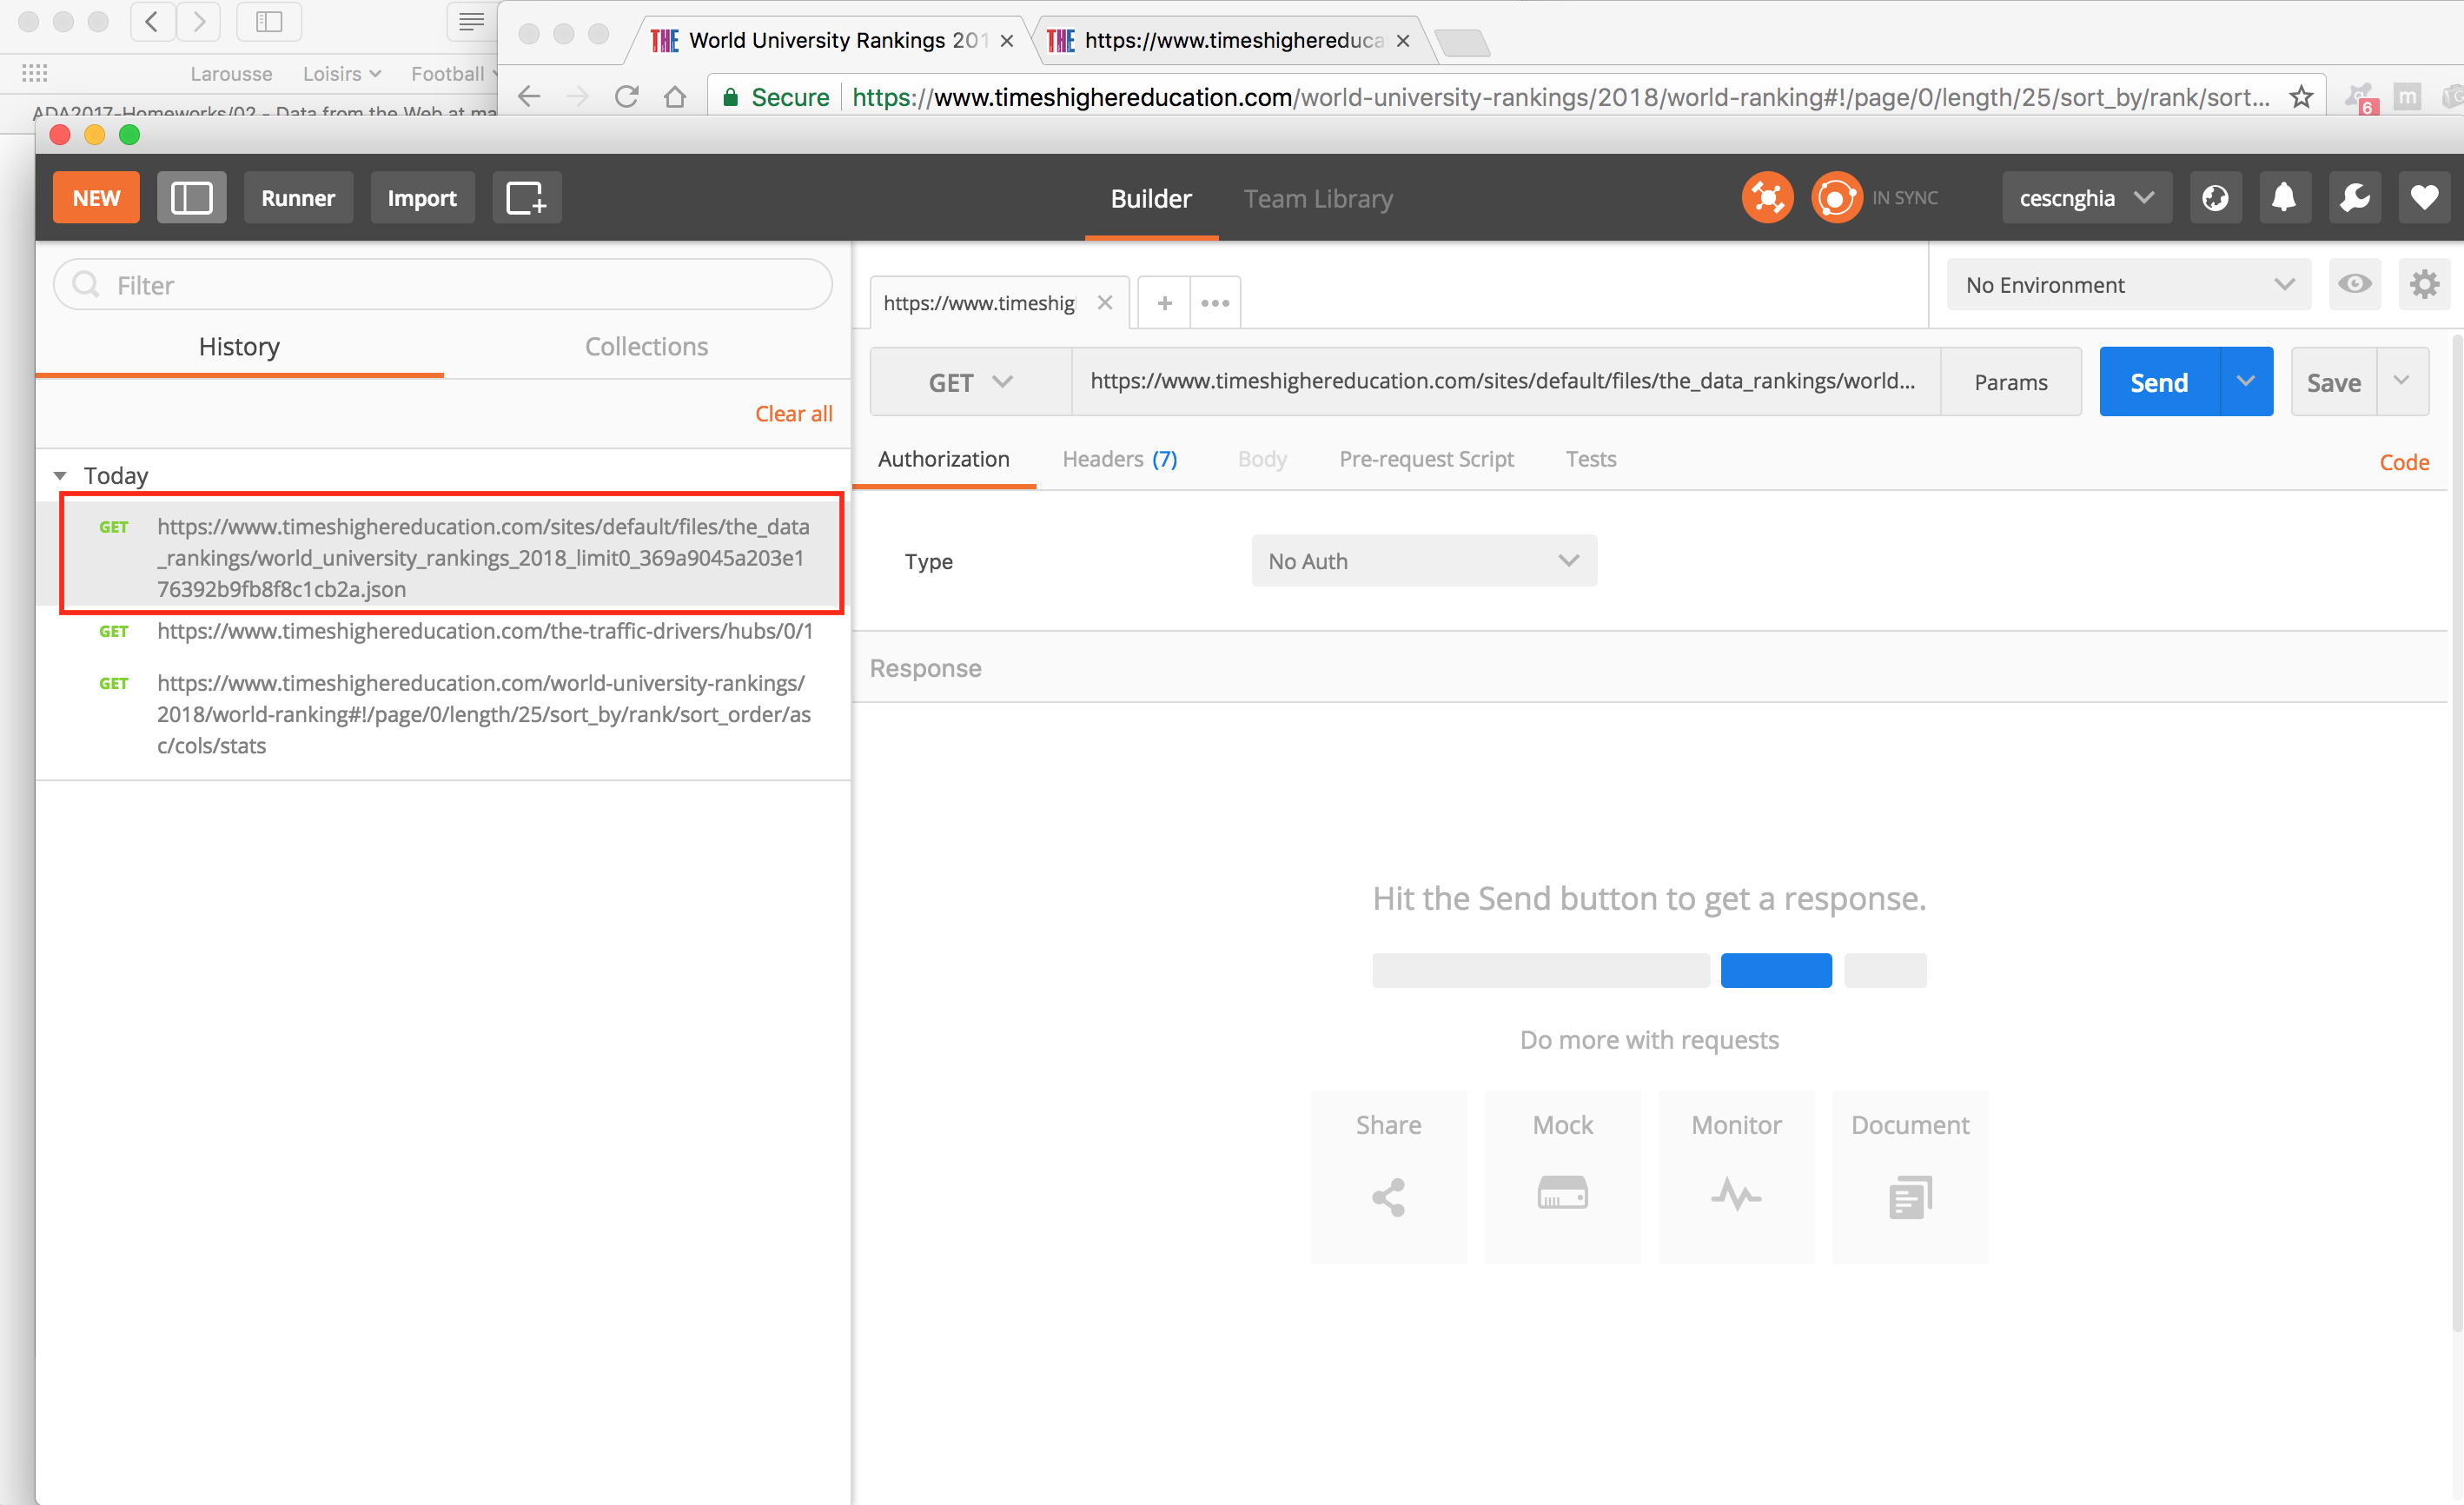

In [22]:
Image(filename='../data_2_detected.png')

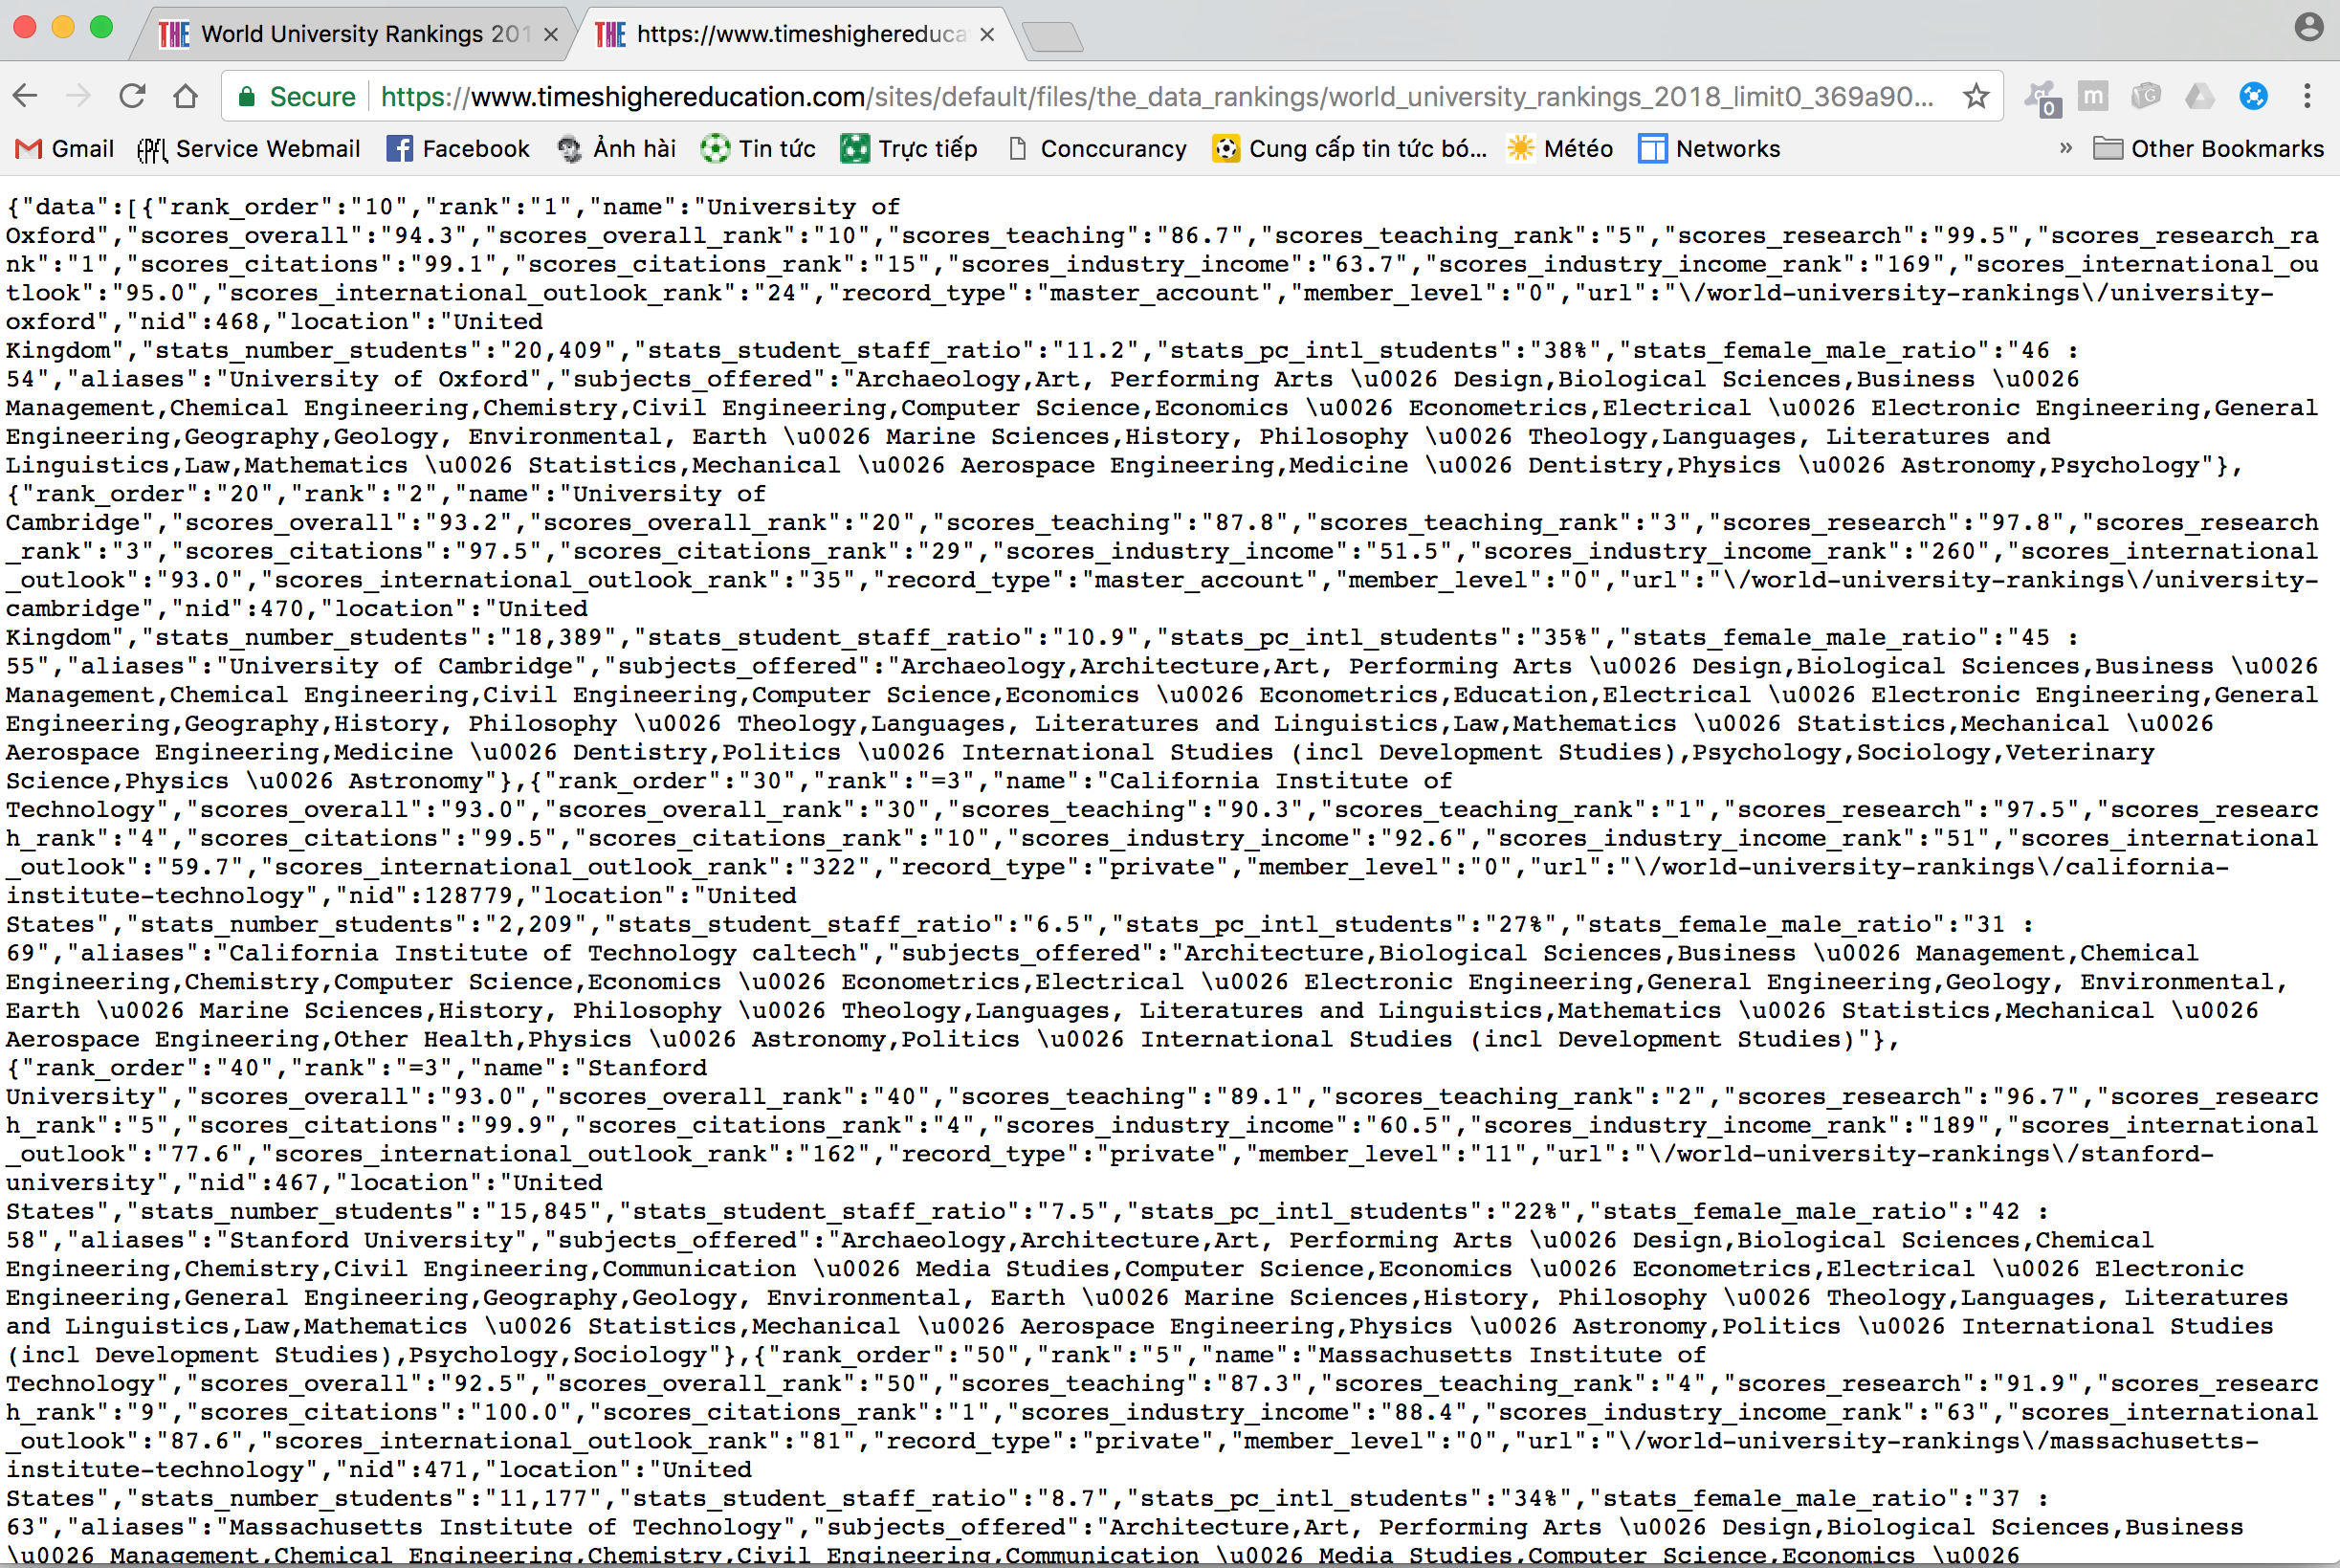

In [23]:
Image(filename='../data_2.png')

In [24]:
MAGIC_TOKEN_2 = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
data_2 = requests.get(MAGIC_TOKEN_2)
data_2 = json.loads(data_2.text)
data_2['data'][9]

{'aliases': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'location': 'Switzerland',
 'member_level': '0',
 'name': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'nid': 479,
 'rank': '=10',
 'rank_order': '100',
 'record_type': 'master_account',
 'scores_citations': '94.3',
 'scores_citations_rank': '60',
 'scores_industry_income': '60.3',
 'scores_industry_income_rank': '190',
 'scores_international_outlook': '98.1',
 'scores_international_outlook_rank': '8',
 'scores_overall': '87.7',
 'scores_overall_rank': '100',
 'scores_research': '92.0',
 'scores_research_rank': '8',
 'scores_teaching': '76.4',
 'scores_teaching_rank': '21',
 'stats_female_male_ratio': '31 : 69',
 'stats_number_students': '19,233',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '14.6',
 'subjects_offered': 'Agriculture & Forestry,Architecture,Biological Sciences,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineeri

In [25]:
"""
    This function return a dataframe of ranking.
    In order to simplify for answering the questions, we computed some necessary information like:
        FEMALE_RATIO, INTERNATIONAL_STUDENT_RATIO...
        
    In order to merge (as well as we can) 2 rankings that comes up after, 
        we have to treat all special cases of the name of university (as most like we do for the first ranking)
        More explications in 3)MERGE
"""

def RANKING_2(data):
    
    names = []
    ranks = []
    countries = []
    total_std = []
    female_ratio = []
    inter_students_ratio =[]
    std_per_staff = []
    N_stds = 200
    
    """Extract data"""
    for i in range(N_stds):
        d = data['data'][i]
        
        name = ((d['name'].split('('))[0])
        if (name[-1] == ' ') : name = name[:-1]
        if 'É' in name: name = name.replace('É','E')
        if '.' in name: # Washington University in St. Louis',
            s = name.split('.')
            name = ''.join(s)
        if 'ETH Zurich' in name: #extreme case
            name ='ETH Zurich – Swiss Federal Institute of Technology Zurich'
        if ', Chapel Hill' in name: name = 'University of North Carolina at Chapel Hill'
        if ', The University of Dublin' in name: name = 'Trinity College Dublin'
        if 'Studi Universitari e di Perfezionamento' in name: name = 'Scuola Normale Superiore di Pisa'
        if 'Pohang University' in name: name = 'Pohang University of Science and Technology'
        if 'King’s College London'in name: name = "King's College London"
        if 'Humboldt-Universität' in name: name = 'Humboldt University of Berlin'
        if 'Freie Universitaet Berlin' in name: name = 'Free University of Berlin'
        names.append(name)
        
        rank = d['rank']
        ranks.append((rank[1:]) if '=' in rank else (rank))
        countries.append(d['location'])
        
        total_student = d['stats_number_students']
        total_std.append(int(total_student.replace(',','')))
        
        inter_ratio = d['stats_pc_intl_students']
        inter_ratio = inter_ratio.replace('%','')
        inter_ratio = float(inter_ratio.replace(',','.'))
        inter_students_ratio.append(inter_ratio/100)
        
        f_ratio = d['stats_female_male_ratio']
        if f_ratio is not None :
            f_ratio = (((str(f_ratio)).split(':'))[0])[:-1]
            female_ratio.append(float(f_ratio)/100)
        else:
            female_ratio.append(-999)
            
        std_per_staff.append(float(d['stats_student_staff_ratio']))
    """Create dataframe"""
    
    df = pd.DataFrame(
        {
          'RANK'                        : ranks,
          'UNIVERSITY'                  : names,
          'COUNTRY'                     : countries,
          'FEMALE_RATIO'                : female_ratio,
          'STUDENTS_PER_STAFF'          : std_per_staff,
          'NUMBER_OF_STUDENTS'          : total_std,
          'INTERNATIONAL_STUDENT_RATIO' : inter_students_ratio
        })    
    
    return df

In [26]:
df_2 = RANKING_2(data_2)
df_2

COUNTRY  FEMALE_RATIO  INTERNATIONAL_STUDENT_RATIO  \
0        United Kingdom          0.46                         0.38   
1        United Kingdom          0.45                         0.35   
2         United States          0.31                         0.27   
3         United States          0.42                         0.22   
4         United States          0.37                         0.34   
5         United States       -999.00                         0.26   
6         United States          0.45                         0.24   
7        United Kingdom          0.37                         0.55   
8         United States          0.44                         0.25   
9           Switzerland          0.31                         0.38   
10        United States          0.50                         0.20   
11        United States          0.49                         0.21   
12        United States          0.52                         0.24   
13        United States       -999.00                         0.32   
14        United States          0.53                         0.17   
15       United Kingdom          0.56                         0.49   
16        United States          0.49                         0.22   
17        United States          0.52                         0.17   
18        United States          0.49                         0.24   
19        United States          0.48                         0.18   
20        United States          0.48                         0.16   
21            Singapore          0.51                         0.30   
22               Canada       -999.00                         0.17   
23        United States          0.39                         0.45   
24       United Kingdom          0.52                         0.71   
25        United States          0.52                         0.16   
26       United Kingdom          0.59                         0.40   
27        United States          0.56                         0.26   
28                China          0.47                         0.16   
29                China          0.32                         0.09   
..                  ...           ...                          ...   
170        South Africa          0.53                         0.18   
171       United States          0.52                         0.10   
172              Sweden          0.33                         0.17   
173             Germany          0.53                         0.07   
174             Belgium          0.55                         0.35   
175      United Kingdom          0.49                         0.30   
176      United Kingdom          0.54                         0.35   
177               China          0.22                         0.06   
178          Luxembourg          0.50                         0.57   
179         Netherlands          0.37                         0.27   
180              France          0.55                         0.16   
181              France          0.47                         0.13   
182           Hong Kong          0.51                         0.25   
183               Italy          0.30                         0.07   
184      United Kingdom          0.55                         0.36   
185       United States          0.51                         0.16   
186      United Kingdom          0.62                         0.24   
187      United Kingdom          0.60                         0.30   
188               China          0.41                         0.06   
189             Finland          0.34                         0.20   
190       United States          0.49                         0.14   
191         New Zealand          0.54                         0.29   
192       United States          0.49                         0.32   
193  Russian Federation          0.48                         0.22   
194         Netherlands          0.48                         0.13   
195              France   

## Question a 

In [27]:
df_2a = df_2[['RANK', 'UNIVERSITY', 'STUDENTS_PER_STAFF']]
df_2a = df_2a.set_index('STUDENTS_PER_STAFF')
df_2a = df_2a.sort_index(axis=0,ascending=False)
df_2a

RANK                                     UNIVERSITY
STUDENTS_PER_STAFF                                                    
77.9                100                             University of Bonn
74.5                125                         University of Mannheim
64.3                 92                 Technical University of Berlin
58.5                162               University of Erlangen-Nuremberg
57.7                 79                         RWTH Aachen University
57.0                 88                      Free University of Berlin
56.5                 62                  Humboldt University of Berlin
54.4                 41                 Technical University of Munich
50.9                145                          University of Cologne
43.4                175                  Université Libre de Bruxelles
42.6                173                          University of Münster
40.3                 82                         University of Freiburg
38.5                 94                         University of Tübingen
37.8                129               Université Catholique de Louvain
37.1                 47                                      KU Leuven
35.9                107                               Ghent University
35.9                155                                     TU Dresden
35.7                 65                       University of Queensland
34.3                134                         University of Adelaide
33.9                165                         University of Würzburg
33.7                 80                              Monash University
30.2                196            Paris-Sorbonne University – Paris 4
28.4                155                                 Ulm University
28.1                 53        University of California, Santa Barbara
27.9                113                        University of Göttingen
26.9                182               Hong Kong Polytechnic University
26.7                 85                  University of New South Wales
26.6                 32                        University of Melbourne
26.3                133              Karlsruhe Institute of Technology
24.9                134                           Stockholm University
...                 ...                                            ...
8.7                  74                               Kyoto University
8.6                  21                         University of Michigan
8.6                 123                          Georgetown University
8.6                  70                              Boston University
8.5                 182               Ecole Normale Supérieure de Lyon
8.3                   7                           Princeton University
8.2                 132  University of Science and Technology of China
7.5                  50              Washington University in St Louis
7.5                   3                            Stanford University
7.3                 194              Lomonosov Moscow State University
7.1                 158                Case Western Reserve University
6.7                  46                            University of Tokyo
6.6                  89                              Dartmouth College
6.5                  10                     University of Pennsylvania
6.5                   3             California Institute of Technology
6.2                   9                          University of Chicago
6.1                  14                            Columbia University
6.0                 153                Technical University of Denmark
5.9                 136                           University of Zurich
5.9                 186                            University of Miami
5.9                 100                       University of Pittsburgh
5.2                 184               Scuola Normale Superiore di Pisa
5.1                 115                            Ecole Polytechnique
4.5                  17                    

## Question b

In [28]:
df_2b = df_2[['RANK', 'UNIVERSITY', 'INTERNATIONAL_STUDENT_RATIO']]
df_2b = df_2b.set_index('INTERNATIONAL_STUDENT_RATIO')
df_2b = df_2b.sort_index(axis=0,ascending=False)
df_2b

RANK  \
INTERNATIONAL_STUDENT_RATIO        
0.71                          25   
0.57                         179   
0.55                          38   
0.55                           8   
0.50                         103   
0.49                          16   
0.48                         143   
0.45                          24   
0.45                         121   
0.42                          40   
0.41                          36   
0.40                          27   
0.40                          32   
0.40                         197   
0.40                         130   
0.39                          91   
0.38                           1   
0.38                          54   
0.38                          10   
0.38                         159   
0.38                         147   
0.38                         150   
0.36                         185   
0.36                         104   
0.36                         115   
0.36                          80   
0.35                           2   
0.35                         119   
0.35                          48   
0.35                         177   
...                          ...   
0.10                         169   
0.10                         145   
0.10                          46   
0.10                          49   
0.10                          54   
0.10                          69   
0.10                         100   
0.10                         107   
0.10                         116   
0.09                         159   
0.09                         161   
0.09                          30   
0.09                         165   
0.09                         143   
0.09                          95   
0.08                          74   
0.08                          56   
0.08                         134   
0.08                         198   
0.07                         184   
0.07                          68   
0.07                         165   
0.07                         173   
0.06                         168   
0.06                         177   
0.06                         188   
0.06                          90   
0.04                         162   
0.04                         137   
0.03                         132   

                                                                    UNIVERSITY  
INTERNATIONAL_STUDENT_RATIO                                                     
0.71                          London School of Economics and Political Science  
0.57                                                  University of Luxembourg  
0.55                                  Ecole Polytechnique Fédérale de Lausanne  
0.55                                                   Imperial College London  
0.50                                                     Maastricht University  
0.49                                                 University College London  
0.48                                                  University of St Andrews  
0.45                                                Carnegie Mellon University  
0.45                                           Queen Mary University of London  
0.42                                                   University of Hong Kong  
0.41                                                     King's College London  
0.40                                                   University of Edinburgh  
0.40                                                   University of Melbourne  
0.40                                      Royal Holloway, University of London  
0.40                                                      University of Geneva  
0.39                                                     University of Warwick  
0.38                                                      University of Oxford  
0.38                                                  University of Manchester  
0.38                         ETH Zurich – Swiss Federal Institute of Techno...  
0.38                                                   Uni

## Question c

In [29]:
df_2c1 = df_2[['RANK', 'UNIVERSITY','COUNTRY', 'STUDENTS_PER_STAFF']]
df_2c1 = df_2c1.sort_values('COUNTRY')
df_2c1 = df_2c1.set_index(['COUNTRY','STUDENTS_PER_STAFF'])
df_2c1 = df_2c1.sort_index(axis=0, ascending=False)
df_2c1

RANK  \
COUNTRY       STUDENTS_PER_STAFF        
United States 28.1                 53   
              23.6                159   
              23.0                162   
              22.8                 37   
              20.7                198   
              20.7                 33   
              20.1                126   
              17.5                143   
              17.4                 60   
              17.4                 56   
              17.1                 49   
              17.0                 99   
              17.0                 83   
              16.5                 69   
              16.3                100   
              15.2                 77   
              15.2                168   
              14.1                117   
              14.0                193   
              13.8                 54   
              13.5                 24   
              13.4                150   
              13.3                191   
              13.1                 18   
              13.0                161   
              12.8                 20   
              12.8                 31   
              12.8                 66   
              12.7                 70   
              11.4                 25   
...                               ...   
Finland       16.2                 90   
Denmark       14.3                109   
              6.0                 153   
              4.1                 109   
China         14.2                169   
              14.1                177   
              13.7                 30   
              12.4                188   
              12.1                116   
              8.9                  27   
              8.2                 132   
Canada        24.7                 78   
              21.9                108   
              21.6                119   
              18.7                 22   
              18.1                 34   
              13.3                 42   
Belgium       43.4                175   
              37.8                129   
              37.1                 47   
              35.9                107   
Austria       20.8                165   
Australia     35.7                 65   
              34.3                134   
              33.7                 80   
              26.7                 85   
              26.6                 32   
              21.8                111   
              21.6                 61   
              19.3                 48   

                                                                     UNIVERSITY  
COUNTRY       STUDENTS_PER_STAFF                                                 
United States 28.1                      University of California, Santa Barbara  
              23.6                                         Texas A&M University  
              23.0                         University of California, Santa Cruz  
              22.8                   University of Illinois at Urbana-Champaign  
              20.7                          University of California, Riverside  
              20.7                              Georgia Institute of Technology  
              20.1                                     Arizona State University  
              17.5                                        University of Florida  
              17.4                                            Purdue University  
              17.4                                      University of Minnesota  
              17.1                                University of Texas at Austin  
              17.0                             University of California, Irvine  
              17.0                                    Michigan State University  
              16.5                         University of Maryland, College Park  
              16.3                               University of Colorado Boulder  
              15.2                                Penns

In [30]:
"""If needed, we can filter by country"""

df_2c1.iloc[df_2c1.index.get_level_values('COUNTRY') == 'Switzerland']

RANK  \
COUNTRY     STUDENTS_PER_STAFF        
Switzerland 17.7                 95   
            16.5                105   
            15.1                130   
            14.6                 10   
            13.6                152   
            11.2                 38   
            5.9                 136   

                                                                       UNIVERSITY  
COUNTRY     STUDENTS_PER_STAFF                                                     
Switzerland 17.7                                              University of Basel  
            16.5                                               University of Bern  
            15.1                                             University of Geneva  
            14.6                ETH Zurich – Swiss Federal Institute of Techno...  
            13.6                                           University of Lausanne  
            11.2                         Ecole Polytechnique Fédérale de Lausanne  
            5.9                                              University of Zurich

In [31]:
df_2c2 = df_2[['RANK', 'UNIVERSITY','COUNTRY', 'INTERNATIONAL_STUDENT_RATIO']]
df_2c2 = df_2c2.sort_values('COUNTRY')
df_2c2 = df_2c2.set_index(['COUNTRY','INTERNATIONAL_STUDENT_RATIO'])
df_2c2 = df_2c2.sort_index(axis=0, ascending=False)
df_2c2

RANK  \
COUNTRY       INTERNATIONAL_STUDENT_RATIO        
United States 0.45                          24   
              0.34                           5   
              0.32                          14   
              0.32                         193   
              0.29                         153   
              0.28                          86   
              0.27                           3   
              0.27                          33   
              0.26                           6   
              0.26                          27   
              0.25                           9   
              0.25                          70   
              0.24                          13   
              0.24                          19   
              0.24                           7   
              0.23                          60   
              0.23                          37   
              0.23                          66   
              0.22                          17   
              0.22                           3   
              0.21                          12   
              0.21                          99   
              0.20                          10   
              0.20                          50   
              0.19                          98   
              0.19                         126   
              0.19                         158   
              0.18                          20   
              0.17                          18   
              0.17                          15   
...                                        ...   
Finland       0.06                          90   
Denmark       0.24                         153   
              0.14                         109   
              0.12                         109   
China         0.16                          27   
              0.10                         169   
              0.10                         116   
              0.09                          30   
              0.06                         188   
              0.06                         177   
              0.03                         132   
Canada        0.29                          34   
              0.26                         119   
              0.26                          42   
              0.22                         108   
              0.17                          22   
              0.15                          78   
Belgium       0.35                         175   
              0.19                         129   
              0.15                          47   
              0.10                         107   
Austria       0.26                         165   
Australia     0.40                          32   
              0.35                          48   
              0.34                          85   
              0.32                          61   
              0.28                          80   
              0.26                         134   
              0.26                          65   
              0.25                         111   

                                                                              UNIVERSITY  
COUNTRY       INTERNATIONAL_STUDENT_RATIO                                                 
United States 0.45                                            Carnegie Mellon University  
              0.34                                 Massachusetts Institute of Technology  
              0.32                                                   Columbia University  
              0.32                                               Northeastern University  
              0.29                                               University of Rochester  
              0.28                                                       Rice University  
              0.27                                    California Institute of Technology  
              0.27                                       Georgia Institu

In [32]:
"""If needed, we can filter by country"""

df_2c2.iloc[df_2c2.index.get_level_values('COUNTRY') == 'United Kingdom']

RANK  \
COUNTRY        INTERNATIONAL_STUDENT_RATIO        
United Kingdom 0.71                          25   
               0.55                           8   
               0.49                          16   
               0.48                         143   
               0.45                         121   
               0.41                          36   
               0.40                          27   
               0.40                         197   
               0.39                          91   
               0.38                         147   
               0.38                         150   
               0.38                         159   
               0.38                          54   
               0.38                           1   
               0.36                         104   
               0.36                         185   
               0.36                          80   
               0.35                         177   
               0.35                           2   
               0.33                         126   
               0.30                         147   
               0.30                         175   
               0.30                         188   
               0.29                          97   
               0.28                         130   
               0.27                         141   
               0.27                         137   
               0.27                          76   
               0.26                         139   
               0.26                         162   
               0.24                         187   

                                                                                  UNIVERSITY  
COUNTRY        INTERNATIONAL_STUDENT_RATIO                                                    
United Kingdom 0.71                         London School of Economics and Political Science  
               0.55                                                  Imperial College London  
               0.49                                                University College London  
               0.48                                                 University of St Andrews  
               0.45                                          Queen Mary University of London  
               0.41                                                    King's College London  
               0.40                                                  University of Edinburgh  
               0.40                                     Royal Holloway, University of London  
               0.39                                                    University of Warwick  
               0.38                                                     University of Sussex  
               0.38                                                     Lancaster University  
               0.38                                                  University of Leicester  
               0.38                                                 University of Manchester  
               0.38                                                     University of Oxford  
               0.36                                                  University of Sheffield  
               0.36                                                   University of Aberdeen  
               0.36                                                    University of Glasgow  
               0.35                                                  University of Liverpool  
               0.35                                                  University of Cambridge  
               0.33                                                University of Southampton  
               0.30                                                 University of Nottingham  
               0.30                                                     Newcastle University  
               0.30                                                University o

## Question d (not enough information about REGION)

# 3) Merge

In [33]:
df_1.head()

COUNTRY  INTERNATIONAL_STUDENT_RATIO  NUMBER_OF_STUDENTS  RANK  \
0   United States                         0.34               11067     1   
1   United States                         0.23               15878     2   
2   United States                         0.23               22429     3   
3   United States                         0.29                2255     4   
4  United Kingdom                         0.36               18770     5   

          REGION  STUDENTS_PER_STAFF                             UNIVERSITY  
0  North America                 3.7  Massachusetts Institute of Technology  
1  North America                 3.7                    Stanford University  
2  North America                 5.2                     Harvard University  
3  North America                 2.4     California Institute of Technology  
4         Europe                 3.4                University of Cambridge

In [34]:
df_2.head()

COUNTRY  FEMALE_RATIO  INTERNATIONAL_STUDENT_RATIO  \
0  United Kingdom          0.46                         0.38   
1  United Kingdom          0.45                         0.35   
2   United States          0.31                         0.27   
3   United States          0.42                         0.22   
4   United States          0.37                         0.34   

   NUMBER_OF_STUDENTS RANK  STUDENTS_PER_STAFF  \
0               20409    1                11.2   
1               18389    2                10.9   
2                2209    3                 6.5   
3               15845    3                 7.5   
4               11177    5                 8.7   

                              UNIVERSITY  
0                   University of Oxford  
1                University of Cambridge  
2     California Institute of Technology  
3                    Stanford University  
4  Massachusetts Institute of Technology

In [35]:
"""Do outer merge on UNIVERSITY (name), as I said, replace all NaN values by int -999

   Strategy: Merge 1000 times and then look up and treat every sigle special cases that we have:
       + remove (): Massachusetts Institute of Technology(MIT) => Massachusetts Institute of Technology
       + replace 'É' by 'E'
       + replace 'St. Louis' by 'St Louis'
       + replace ', Chapel Hill' by 'Chapel Hill'
       + ....

"""
df = df_1.merge(df_2, how='outer', on = 'UNIVERSITY').fillna(-999)
df

COUNTRY_x  INTERNATIONAL_STUDENT_RATIO_x  NUMBER_OF_STUDENTS_x  \
0     United States                           0.34               11067.0   
1     United States                           0.23               15878.0   
2     United States                           0.23               22429.0   
3     United States                           0.29                2255.0   
4    United Kingdom                           0.36               18770.0   
5    United Kingdom                           0.37               19720.0   
6    United Kingdom                           0.48               31080.0   
7    United Kingdom                           0.54               16090.0   
8     United States                           0.25               13557.0   
9       Switzerland                           0.38               19815.0   
10        Singapore                           0.28               25738.0   
11      Switzerland                           0.57               10343.0   
12    United States                           0.22                8069.0   
13    United States                           0.25               21904.0   
14        Singapore                           0.27               32728.0   
15    United States                           0.20               12402.0   
16    United States                           0.25               16146.0   
17    United States                           0.32               25045.0   
18    United States                           0.21               20639.0   
19        Australia                           0.38               14442.0   
20    United States                           0.17               43147.0   
21    United States                           0.19               15320.0   
22   United Kingdom                           0.38               28040.0   
23   United Kingdom                           0.40               23780.0   
24            China                           0.11               36300.0   
25        Hong Kong                           0.41               20214.0   
26    United States                           0.17               36703.0   
27            Japan                           0.10               27279.0   
28    United States                           0.18               18675.0   
29        Hong Kong                           0.28               10375.0   
..              ...                            ...                   ...   
244            -999                        -999.00                -999.0   
245            -999                        -999.00                -999.0   
246            -999                        -999.00                -999.0   
247            -999                        -999.00                -999.0   
248            -999                        -999.00                -999.0   
249            -999                        -999.00                -999.0   
250            -999                        -999.00                -999.0   
251            -999                        -999.00                -999.0   
252            -999                        -999.00                -999.0   
253            -999                        -999.00                -999.0   
254            -999                        -999.00                -999.0   
255            -999                        -999.00                -999.0   
256            -999                        -999.00                -999.0   
257            -999                        -999.00                -999.0   
258            -999                        -999.00                -999.0   
259            -999                        -999.00                -999.0   
260            -999                        -999.00                -999.0   
261            -999                        -999.00                -999.0   
262            -999                        -999.00                -999.0   
263            -999                        -999.00                -999.0   
264            -999                        -999.00        

In [36]:
"""Look up if there still is a special case """

sorted(df.UNIVERSITY)

['Aalto University',
 'Aarhus University',
 'Albert-Ludwigs-Universitaet Freiburg',
 'Alma Mater Studiorum - University of Bologna',
 'Arizona State University',
 'Australian National University',
 'Autonomous University of Barcelona',
 'Boston University',
 'Brown University',
 'California Institute of Technology',
 'Cardiff University',
 'Carnegie Mellon University',
 'Case Western Reserve University',
 'CentraleSupélec',
 'Chalmers University of Technology',
 'Charité - Universitätsmedizin Berlin',
 'Chinese University of Hong Kong',
 'City University of Hong Kong',
 'Columbia University',
 'Cornell University',
 'Dartmouth College',
 'Delft University of Technology',
 'Duke University',
 'Durham University',
 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'Eberhard Karls Universität Tübingen',
 'Ecole Normale Supérieure de Lyon',
 'Ecole Polytechnique',
 'Ecole Polytechnique Fédérale de Lausanne',
 'Ecole normale supérieure, Paris',
 'Eindhoven University of Technolo

In [37]:
""" Columns in new dataframe"""
df.columns

Index(['COUNTRY_x', 'INTERNATIONAL_STUDENT_RATIO_x', 'NUMBER_OF_STUDENTS_x',
       'RANK_x', 'REGION', 'STUDENTS_PER_STAFF_x', 'UNIVERSITY', 'COUNTRY_y',
       'FEMALE_RATIO', 'INTERNATIONAL_STUDENT_RATIO_y', 'NUMBER_OF_STUDENTS_y',
       'RANK_y', 'STUDENTS_PER_STAFF_y'],
      dtype='object')

In [38]:
""" Now we have to merge the others columns like (COUNTRY_x, COUNTRY_y)
    If a row has 2 valid values => take one (not important which one)
    Otherwise take a valid one (of course there is at least one valid value)
    
    E.g: if STUDENTS_PER_STAFF_x of EPFL is 5 and STUDENTS_PER_STAFF_y of EPFL is 4
             than we just take either 4 or 5
         if STUDENTS_PER_STAFF_x of EPFL is -999 (mean NaN) and STUDENTS_PER_STAFF_y of EPFL is 4
             than we have to take 4
         
"""

countries = []
temp = df['COUNTRY_y']
for idx, c in enumerate(df['COUNTRY_x']):
    country = c if (c == temp[idx]) else (c if c != -999 else temp[idx])
    countries.append(country)    
df['COUNTRY'] = countries

"--------------------------------------------------------------------------------"

inter_ratio = []
temp = df['INTERNATIONAL_STUDENT_RATIO_y']
for idx, c in enumerate(df['INTERNATIONAL_STUDENT_RATIO_x']):
    ratio = c if (c == temp[idx]) else (c if c != -999 else temp[idx])
    inter_ratio.append(ratio)
df['STUDENT_INTERNATIONAL_RATIO'] = inter_ratio

"--------------------------------------------------------------------------------"

students_per_staff = []
temp = df['STUDENTS_PER_STAFF_y']
for idx, c in enumerate(df['STUDENTS_PER_STAFF_x']):
    number = c if (c == temp[idx]) else (c if c != -999 else temp[idx])
    students_per_staff.append(number)
df['STUDENTS_PER_STAFF'] = students_per_staff

"--------------------------------------------------------------------------------"

total_students = []
temp = df['NUMBER_OF_STUDENTS_y']
for idx, c in enumerate(df['NUMBER_OF_STUDENTS_x']):
    number = c if (c == temp[idx]) else (c if c != -999 else temp[idx])
    total_students.append(number)
    
df['NUMBER_OF_STUDENT'] = total_students

In [39]:
"""Rename and drop some unnecessary columns"""

df = df.rename(columns={'RANK_x': 'RANK_TOP'
                        , 'RANK_y': 'RANK_TIMES'
                        })

df = df.drop(['COUNTRY_x'                    ,'COUNTRY_y',
              'INTERNATIONAL_STUDENT_RATIO_x','INTERNATIONAL_STUDENT_RATIO_y',
              'NUMBER_OF_STUDENTS_x'         ,'NUMBER_OF_STUDENTS_y',
              'STUDENTS_PER_STAFF_x'         ,'STUDENTS_PER_STAFF_y'], 1)

df[['RANK_TOP']] = df[['RANK_TOP']].astype(int)
df[['RANK_TIMES']] = df[['RANK_TIMES']].astype(int)
df[['NUMBER_OF_STUDENT']] = df[['NUMBER_OF_STUDENT']].astype(int)
df = df[['UNIVERSITY', 'COUNTRY', 'RANK_TOP', 'RANK_TIMES','STUDENT_INTERNATIONAL_RATIO',
         'NUMBER_OF_STUDENT','STUDENTS_PER_STAFF', 'FEMALE_RATIO','REGION']]

In [40]:
df

UNIVERSITY         COUNTRY  \
0                Massachusetts Institute of Technology   United States   
1                                  Stanford University   United States   
2                                   Harvard University   United States   
3                   California Institute of Technology   United States   
4                              University of Cambridge  United Kingdom   
5                                 University of Oxford  United Kingdom   
6                                                  UCL  United Kingdom   
7                              Imperial College London  United Kingdom   
8                                University of Chicago   United States   
9    ETH Zurich – Swiss Federal Institute of Techno...     Switzerland   
10         Nanyang Technological University, Singapore       Singapore   
11            Ecole Polytechnique Fédérale de Lausanne     Switzerland   
12                                Princeton University   United States   
13                                  Cornell University   United States   
14                    National University of Singapore       Singapore   
15                                     Yale University   United States   
16                            Johns Hopkins University   United States   
17                                 Columbia University   United States   
18                          University of Pennsylvania   United States   
19                  The Australian National University       Australia   
20                              University of Michigan   United States   
21                                     Duke University   United States   
22                         The University of Edinburgh  United Kingdom   
23                               King's College London  United Kingdom   
24                                 Tsinghua University           China   
25                         The University of Hong Kong       Hong Kong   
26                  University of California, Berkeley   United States   
27                             The University of Tokyo           Japan   
28                             Northwestern University   United States   
29   The Hong Kong University of Science and Techno...       Hong Kong   
..                                                 ...             ...   
244                           University of Notre Dame   United States   
245                         Scuola Superiore Sant’Anna           Italy   
246                                         TU Dresden         Germany   
247                                     Ulm University         Germany   
248                    Case Western Reserve University   United States   
249                            University of Leicester  United Kingdom   
250                              University of Arizona   United States   
251               University of California, Santa Cruz   United States   
252                   University of Erlangen-Nuremberg         Germany   
253                       Vrije Universiteit Amsterdam     Netherlands   
254                             University of Würzburg         Germany   
255                University of Alabama at Birmingham   United States   
256                                   Tufts University   United States   
257        Rutgers, the State University of New Jersey   United States   
258                              University of Münster         Germany   
259                      Université Libre de Bruxelles         Belgium   
260                           University of Luxembourg      Luxembourg   
261                               Paris-Sud University          France   
262                   Hong Kong Polytechnic University       Hong Kong   
263                                University of Miami   United States   
264                               University of Dundee  United Kingdom   
265                          University of East Anglia  United Kingdom   
266                        University of Massach

# 4) Exploratory Analysis

* *STUDENTS_PER_STAFF* has a strong correlation with *RANK*: if we have a bigger number of staffs then the rank tends to go higher.
* *STUDENT_INTERNATIONAL_RATIO* has also a strong correlation with *RANK*: most of top ranked university has this ratio bigger than 20%. It's logic because students tend to go abroad to an university with a high rank (reputation), also in the opposite direction, university can choose students with good quality and then its rank will maybe go higher...

# 5) Best university ?
* RANK = .5 * RANK_TOP + .5 * RANK_TIMES

In [41]:
"""One simple way to rank these universities is take the average of 2 ranks """

df['RANK_TOP'].replace(-999, 999,inplace=True)
df['RANK_TIMES'].replace(-999, 999,inplace=True)

ranks = []
r_1 = df['RANK_TOP']
for idx, r_2 in enumerate(df['RANK_TIMES']):
    ranks.append((r_1[idx]+r_2)/2)

df.insert(4, 'COMBINED_RANK', ranks)
df = df.sort_values('COMBINED_RANK')
df
"""Mapping the average [2.5, 4, 5....] to [1, 2, 3]"""
rank_mapping = [0]*len(ranks)
for (ind, rank) in enumerate(df.COMBINED_RANK):
    rank_mapping[ind] = ind + 1
df['COMBINED_RANK'] = rank_mapping
df = df.set_index(['COMBINED_RANK'])
df = df.sort_index(axis=0)
df

UNIVERSITY  \
COMBINED_RANK                                                      
1                                            Stanford University   
2                          Massachusetts Institute of Technology   
3                             California Institute of Technology   
4                                        University of Cambridge   
5                                           University of Oxford   
6                                             Harvard University   
7                                        Imperial College London   
8                                          University of Chicago   
9              ETH Zurich – Swiss Federal Institute of Techno...   
10                                          Princeton University   
11                                               Yale University   
12                                    University of Pennsylvania   
13                                      Johns Hopkins University   
14                                           Columbia University   
15                                            Cornell University   
16                              National University of Singapore   
17                                               Duke University   
18                                        University of Michigan   
19                            University of California, Berkeley   
20                                       Northwestern University   
21                         University of California, Los Angeles   
22                      Ecole Polytechnique Fédérale de Lausanne   
23                                         University of Toronto   
24                                           Tsinghua University   
25                                         King's College London   
26              London School of Economics and Political Science   
27                   Nanyang Technological University, Singapore   
28                                             Peking University   
29                           University of California, San Diego   
30                                    Carnegie Mellon University   
...                                                          ...   
245                                        University of Münster   
246                                Université Libre de Bruxelles   
247                              University of Technology Sydney   
248                                              CentraleSupélec   
249                        Indian Institute of Technology Bombay   
250                                     University of Luxembourg   
251                                         Paris-Sud University   
252                             Hong Kong Polytechnic University   
253                                   Vrije Universiteit Brussel   
254                            Universidade Estadual de Campinas   
255                              Vienna University of Technology   
256                                          University of Miami   
257                                         University of Dundee   
258                               Universidad Autónoma de Madrid   
259                                        University of Reading   
260                 Alma Mater Studiorum - University of Bologna   
261                                    University of East Anglia   
262                                  Indian Institute of Science   
263                                  University of Massachusetts   
264                                       University of Auckland   
265                                     Keio University CEMS MIM   
266                                      Northeastern University   
267                            Universitat Autònoma de Barcelona   
268                                           Tilburg University   
269                          Paris-Sorbonne University – Paris 4   
270                         Royal Holloway, University of London   
271                          University of

In [42]:
"""Finally, replace all invalid values by 'unknown'"""
df.replace(-999, 'unknown', inplace=True)

In [43]:
df

UNIVERSITY  \
COMBINED_RANK                                                      
1                                            Stanford University   
2                          Massachusetts Institute of Technology   
3                             California Institute of Technology   
4                                        University of Cambridge   
5                                           University of Oxford   
6                                             Harvard University   
7                                        Imperial College London   
8                                          University of Chicago   
9              ETH Zurich – Swiss Federal Institute of Techno...   
10                                          Princeton University   
11                                               Yale University   
12                                    University of Pennsylvania   
13                                      Johns Hopkins University   
14                                           Columbia University   
15                                            Cornell University   
16                              National University of Singapore   
17                                               Duke University   
18                                        University of Michigan   
19                            University of California, Berkeley   
20                                       Northwestern University   
21                         University of California, Los Angeles   
22                      Ecole Polytechnique Fédérale de Lausanne   
23                                         University of Toronto   
24                                           Tsinghua University   
25                                         King's College London   
26              London School of Economics and Political Science   
27                   Nanyang Technological University, Singapore   
28                                             Peking University   
29                           University of California, San Diego   
30                                    Carnegie Mellon University   
...                                                          ...   
245                                        University of Münster   
246                                Université Libre de Bruxelles   
247                              University of Technology Sydney   
248                                              CentraleSupélec   
249                        Indian Institute of Technology Bombay   
250                                     University of Luxembourg   
251                                         Paris-Sud University   
252                             Hong Kong Polytechnic University   
253                                   Vrije Universiteit Brussel   
254                            Universidade Estadual de Campinas   
255                              Vienna University of Technology   
256                                          University of Miami   
257                                         University of Dundee   
258                               Universidad Autónoma de Madrid   
259                                        University of Reading   
260                 Alma Mater Studiorum - University of Bologna   
261                                    University of East Anglia   
262                                  Indian Institute of Science   
263                                  University of Massachusetts   
264                                       University of Auckland   
265                                     Keio University CEMS MIM   
266                                      Northeastern University   
267                            Universitat Autònoma de Barcelona   
268                                           Tilburg University   
269                          Paris-Sorbonne University – Paris 4   
270                         Royal Holloway, University of London   
271                          University of